In [7]:
import xarray as xr
import pandas as pd

# Open without dask
ds = xr.open_dataset("../data/IBTrACS.ALL.v04r01.nc", engine="netcdf4")

want = ["sid", "name", "lat", "lon", "wmo_wind", "wmo_pres"]
present = [v for v in want if (v in ds.variables) or (v in ds.coords)]
dss = ds[present]

# ... (pick_source function, loop for vars) ...

storm_dim = next(d for d in dss.dims if "storm" in d.lower())
time_dim  = next(d for d in dss.dims if "time"  in d.lower())

dss_long = dss.stack(obs=(storm_dim, time_dim)).dropna("obs", how="any", subset=["lat", "lon"])

if time_dim in dss_long.variables:
    dss_long = dss_long.drop_vars(time_dim)

df_ibtracs = dss_long.to_dataframe().reset_index()
df_ibtracs = df_ibtracs.rename(columns={storm_dim: "storm", time_dim: "time"})

df_ibtracs.head()


C:\Users\smehedi\AppData\Local\Temp\ipykernel_18068\2032710117.py:19: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'storm', 'obs'} to avoid an error in the future.
  dss_long = dss_long.drop_vars(time_dim)


,obs,sid,name,lat,lon,wmo_wind,wmo_pres,time
0,0,b'1842298N11080',b'UNNAMED',10.9,80.300003,NaN,NaN,1842-10-25 03:00:00.000040256
1,1,b'1842298N11080',b'UNNAMED',10.9,79.800003,NaN,NaN,1842-10-25 06:00:00.000040256
2,2,b'1842298N11080',b'UNNAMED',10.8,79.400002,NaN,NaN,1842-10-25 09:00:00.000040256
3,3,b'1842298N11080',b'UNNAMED',10.8,78.900002,NaN,NaN,1842-10-25 12:00:00.000040256
4,4,b'1842298N11080',b'UNNAMED',10.8,78.400002,NaN,NaN,1842-10-25 15:00:00.000040256


In [8]:
import numpy as np

df = df_ibtracs.copy()

# Drop helper column from stacking
if "obs" in df.columns:
    df = df.drop(columns=["obs"])

# Decode bytes to strings
for col in ["sid", "name"]:
    if col in df.columns and df[col].dtype == object and isinstance(df[col].dropna().iloc[0], (bytes, bytearray)):
        df[col] = df[col].str.decode("utf-8", errors="ignore").str.strip()

# Fix time dtype and remove weird nanoseconds offset
df["time"] = pd.to_datetime(df["time"], errors="coerce").dt.round("H")

# Keep only realistic rows
df = df.dropna(subset=["lat", "lon", "time"]).reset_index(drop=True)

# Optional: focus on modern reanalysis era (works best with ERA5 from 1979+)
df = df[df["time"].dt.year >= 1979].reset_index(drop=True)

# Quick peek
df.head(), df.shape


C:\Users\smehedi\AppData\Local\Temp\ipykernel_18068\4068329562.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time"] = pd.to_datetime(df["time"], errors="coerce").dt.round("H")


(             sid    name        lat        lon  wmo_wind  wmo_pres  \
 0  1978347S20041  ANGELE -30.200001  65.400002       NaN       NaN   
 1  1978347S20041  ANGELE -30.299999  66.300003       NaN       NaN   
 2  1978347S20041  ANGELE -30.299999  67.199997       NaN       NaN   
 3  1978347S20041  ANGELE -30.299999  68.000000       NaN       NaN   
 4  1978347S20041  ANGELE -30.299999  68.800003       NaN       NaN   
 
                  time  
 0 1979-01-01 00:00:00  
 1 1979-01-01 03:00:00  
 2 1979-01-01 06:00:00  
 3 1979-01-01 09:00:00  
 4 1979-01-01 12:00:00  ,
 (308748, 7))

In [9]:
df.to_parquet("../outputs/ibtracs_clean.parquet", index=False)   # needs pyarrow
df.to_csv("../outputs/ibtracs_clean.csv", index=False)
print("Saved parquet + csv")


Saved parquet + csv


In [10]:
import pandas as pd

# Load the clean file (fast)
df = pd.read_parquet("../outputs/ibtracs_clean.parquet")

# Basic time coverage
tmin = df["time"].min()
tmax = df["time"].max()
ymin = df["time"].dt.year.min()
ymax = df["time"].dt.year.max()
n_rows = len(df)
n_storms = df["sid"].nunique()

print(f"Rows: {n_rows:,}")
print(f"Unique storms (sid): {n_storms:,}")
print(f"Time range: {tmin}  →  {tmax}")
print(f"Year range: {ymin}  →  {ymax}")

Rows: 308,748
Unique storms (sid): 4,961
Time range: 1979-01-01 00:00:00  →  2025-08-24 00:00:00
Year range: 1979  →  2025


In [11]:
# Filter years 2000–2024
df_filtered = df[(df["time"].dt.year >= 2000) & (df["time"].dt.year <= 2024)]

# Filter to USA / North Atlantic region
df_filtered = df_filtered[
    (df_filtered["lon"] >= -100) & (df_filtered["lon"] <= -10) &
    (df_filtered["lat"] >= 0)    & (df_filtered["lat"] <= 50)
]

# Reset index for cleanliness
df_filtered = df_filtered.reset_index(drop=True)

print("Rows:", len(df_filtered))
print("Unique storms:", df_filtered["sid"].nunique())
print("Years:", df_filtered["time"].dt.year.min(), "→", df_filtered["time"].dt.year.max())

df_filtered.head()


Rows: 26520
Unique storms: 556
Years: 2000 → 2024


,sid,name,lat,lon,wmo_wind,wmo_pres,time
0,2000142N12262,ALETTA,12.0,-97.800003,NaN,NaN,2000-05-21 00:00:00
1,2000142N12262,ALETTA,12.0,-97.900002,NaN,NaN,2000-05-21 03:00:00
2,2000142N12262,ALETTA,11.9,-97.900002,NaN,NaN,2000-05-21 06:00:00
3,2000142N12262,ALETTA,11.8,-97.900002,NaN,NaN,2000-05-21 09:00:00
4,2000142N12262,ALETTA,11.8,-97.800003,NaN,NaN,2000-05-21 12:00:00


Matplotlib is building the font cache; this may take a moment.


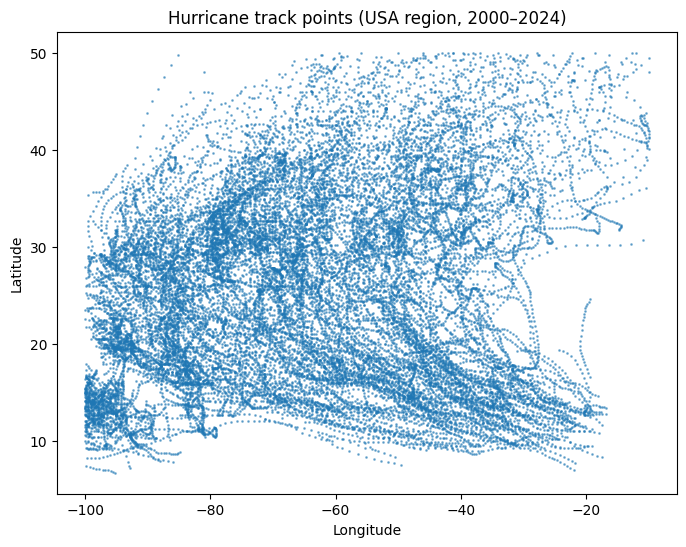

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_filtered["lon"], df_filtered["lat"], s=1, alpha=0.5)
plt.title("Hurricane track points (USA region, 2000–2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [13]:
import xarray as xr, pathlib as pl

files = [
    "data_stream-oper_stepType-instant.nc",
    "data_stream-oper_stepType-accum.nc",
    "ff76ff478dcb9df280181c9f7176c012.nc",
]

for f in files:
    path = f"../data/{f}"
    print("\n----", f, "----")
    try:
        ds = xr.open_dataset(path)
        print("variables:", list(ds.data_vars)[:20])
        print("coords:", list(ds.coords))
        print("time range:", str(ds['time'].values.min())[:19], "→", str(ds['time'].values.max())[:19])
    except Exception as e:
        print("could not open:", e)



---- data_stream-oper_stepType-instant.nc ----
variables: ['u10', 'v10', 't2m', 'msl', 'sst']
coords: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
could not open: "No variable named 'time'. Variables on the dataset include ['u10', 'v10', 't2m', 'msl', 'sst', 'number', 'valid_time', 'latitude', 'longitude', 'expver']"

---- data_stream-oper_stepType-accum.nc ----
variables: ['tp']
coords: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
could not open: "No variable named 'time'. Variables on the dataset include ['tp', 'number', 'valid_time', 'latitude', 'longitude', 'expver']"

---- ff76ff478dcb9df280181c9f7176c012.nc ----
variables: ['u10', 'v10', 'msl']
coords: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
could not open: "No variable named 'time'. Variables on the dataset include ['u10', 'v10', 'msl', 'number', 'valid_time', 'latitude', 'longitude', 'expver']"


In [14]:
import xarray as xr, pathlib as pl

data_dir = pl.Path("../data")
files = list(data_dir.glob("*.nc"))

for f in files:
    print(f"\n---- {f.name} ----")
    try:
        ds = xr.open_dataset(f)
        # rename valid_time -> time if needed
        if "valid_time" in ds.coords:
            ds = ds.rename({"valid_time": "time"})
        # check time coverage
        if "time" in ds.coords:
            t0, t1 = pd.to_datetime(ds.time.values.min()), pd.to_datetime(ds.time.values.max())
            print("time:", t0, "→", t1)
        else:
            print("⚠️ no time coord")
        print("variables:", list(ds.data_vars)[:10], "...")
    except Exception as e:
        print("  could not open:", e)



---- data_stream-oper_stepType-accum.nc ----
time: 2008-01-01 00:00:00 → 2009-12-31 18:00:00
variables: ['tp'] ...

---- data_stream-oper_stepType-instant.nc ----
time: 2008-01-01 00:00:00 → 2009-12-31 18:00:00
variables: ['u10', 'v10', 't2m', 'msl', 'sst'] ...

---- ff76ff478dcb9df280181c9f7176c012.nc ----
time: 2012-01-01 00:00:00 → 2012-12-31 18:00:00
variables: ['u10', 'v10', 'msl'] ...

---- IBTrACS.ALL.v04r01.nc ----
time: NaT → NaT
variables: ['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma'] ...


In [15]:
import xarray as xr, pandas as pd, numpy as np, shutil, pathlib as pl

downloads = pl.Path(r"C:\Users\smehedi\Downloads")
dest      = pl.Path(r"C:\Users\smehedi\OneDrive - Stony Brook University\Documents\HURRICANE_PROJECT\data")
dest.mkdir(parents=True, exist_ok=True)

# find all likely climate files
paths = list(downloads.rglob("*"))
paths = [p for p in paths if p.suffix.lower() in {".nc", ".nc4"}]

rows = []
for p in paths:
    try:
        ds = xr.open_dataset(p)
        if "valid_time" in ds.coords and "time" not in ds.coords:
            ds = ds.rename({"valid_time": "time"})
        # standardize expver/number if present
        if "expver" in ds.dims:
            ds = ds.sel(expver=max(int(v) for v in ds.coords["expver"].values))
        if "number" in ds.dims:
            ds = ds.sel(number=0) if 0 in ds.coords["number"] else ds.mean("number")

        # get time range (if any)
        if "time" in ds.coords and ds.sizes.get("time", 0) > 0:
            t0 = pd.to_datetime(ds["time"].values.min())
            t1 = pd.to_datetime(ds["time"].values.max())
            y0, y1 = t0.year, t1.year
            time_span = f"{y0}-{y1}"
        else:
            t0 = t1 = pd.NaT
            time_span = "no-time"

        vars_list = list(ds.data_vars)
        # create a readable base name: product + years + few vars
        tag_vars = "_".join([v for v in ["sst","t2m","msl","u10","v10","tp"] if v in vars_list]) or "vars"
        base = p.stem[:28]  # avoid super long stems
        out_name = f"{base}_{time_span}_{tag_vars}.nc"
        out_path = dest / out_name

        # avoid duplicating identical time spans/vars by overwriting same name
        shutil.copy2(p, out_path)

        rows.append({
            "source": str(p),
            "copied_as": out_name,
            "time_min": t0,
            "time_max": t1,
            "years": time_span,
            "variables": ", ".join(vars_list[:10])
        })
    except Exception as e:
        rows.append({
            "source": str(p),
            "copied_as": "",
            "time_min": pd.NaT,
            "time_max": pd.NaT,
            "years": "error",
            "variables": f"ERROR: {e}"
        })

summary = pd.DataFrame(rows).sort_values(["years","copied_as"])
summary_reset = summary.reset_index(drop=True)
summary_reset.head(20), summary_reset.tail(20)


(                                               source  \
 0   C:\Users\smehedi\Downloads\59ec8b012e94751cba5...   
 1   C:\Users\smehedi\Downloads\59ec8b012e94751cba5...   
 2   C:\Users\smehedi\Downloads\c786cb9c4c2592d8f12...   
 3   C:\Users\smehedi\Downloads\c786cb9c4c2592d8f12...   
 4   C:\Users\smehedi\Downloads\e4b0acf6627958a830c...   
 5   C:\Users\smehedi\Downloads\e4b0acf6627958a830c...   
 6   C:\Users\smehedi\Downloads\96874c51fde1ef3dd59...   
 7   C:\Users\smehedi\Downloads\96874c51fde1ef3dd59...   
 8   C:\Users\smehedi\Downloads\data_stream-oper_st...   
 9   C:\Users\smehedi\Downloads\f7c015ebdc5acc723b7...   
 10  C:\Users\smehedi\Downloads\data_stream-oper_st...   
 11  C:\Users\smehedi\Downloads\f7c015ebdc5acc723b7...   
 12  C:\Users\smehedi\Downloads\5db0e7d3979e9a13a1f...   
 13  C:\Users\smehedi\Downloads\5db0e7d3979e9a13a1f...   
 14  C:\Users\smehedi\Downloads\12821263718ee2bc236...   
 15  C:\Users\smehedi\Downloads\12821263718ee2bc236...   
 16  C:\Users\

In [16]:
# After running the inventory code earlier:
dupes = summary_reset.groupby("years").size().reset_index(name="count")
dupes[dupes["count"] > 2]   # each span should appear exactly twice (1 instant + 1 accum)

,years,count
4,2008-2009,4


In [17]:
import os

# Filter only the 2008-2009 rows
dupes_0809 = summary_reset[summary_reset["years"] == "2008-2009"]

print("Duplicates for 2008-2009:")
print(dupes_0809[["copied_as", "variables"]])

# Now keep the first of each type ("tp" vs "u10,v10,t2m,msl,sst") and delete the rest
keep = []
for vtype in ["tp", "u10"]:  # tp file + instant file
    rows = dupes_0809[dupes_0809["variables"].str.contains(vtype)]
    if not rows.empty:
        keep.append(rows.iloc[0]["copied_as"])  # keep the first

print("\nKeeping:", keep)

# Delete the extra copies
for _, row in dupes_0809.iterrows():
    fname = row["copied_as"]
    if fname not in keep:
        try:
            os.remove(dest / fname)
            print("Deleted duplicate:", fname)
        except FileNotFoundError:
            pass


Duplicates for 2008-2009:
                                            copied_as                variables
8        data_stream-oper_stepType-ac_2008-2009_tp.nc                       tp
9        data_stream-oper_stepType-ac_2008-2009_tp.nc                       tp
10  data_stream-oper_stepType-in_2008-2009_sst_t2m...  u10, v10, t2m, msl, sst
11  data_stream-oper_stepType-in_2008-2009_sst_t2m...  u10, v10, t2m, msl, sst

Keeping: ['data_stream-oper_stepType-ac_2008-2009_tp.nc', 'data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc']


In [18]:
import os

cleaned = []
for years, group in summary_reset.groupby("years"):
    # For each 2-year span, we want at most 1 tp file and 1 instant file
    tp_files = group[group["variables"].str.contains("tp")]["copied_as"].tolist()
    inst_files = group[~group["variables"].str.contains("tp")]["copied_as"].tolist()
    
    # Keep one tp, delete extras
    if tp_files:
        keep = tp_files[0]
        cleaned.append(keep)
        for f in tp_files[1:]:
            try:
                os.remove(dest / f)
                print("Deleted duplicate:", f)
            except FileNotFoundError:
                pass
    
    # Keep one instant, delete extras
    if inst_files:
        keep = inst_files[0]
        cleaned.append(keep)
        for f in inst_files[1:]:
            try:
                os.remove(dest / f)
                print("Deleted duplicate:", f)
            except FileNotFoundError:
                pass

print("\nCleanup done.")


Deleted duplicate: data_stream-oper_stepType-ac_2008-2009_tp.nc
Deleted duplicate: data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc

Cleanup done.


In [19]:
import pandas as pd

dupes = summary_reset.groupby("years").size().reset_index(name="count")
print(dupes)

# Also list final coverage
coverage = summary_reset.groupby("years")[["time_min","time_max"]].min().reset_index()
print("\nFinal coverage:")
print(coverage)


        years  count
0   2000-2001      2
1   2002-2003      2
2   2004-2005      2
3   2006-2007      2
4   2008-2009      4
5   2010-2011      2
6   2013-2014      2
7   2015-2016      2
8   2017-2018      2
9   2019-2020      2
10  2021-2022      2
11  2023-2024      2

Final coverage:
        years   time_min            time_max
0   2000-2001 2000-01-01 2001-12-31 18:00:00
1   2002-2003 2002-01-01 2003-12-31 18:00:00
2   2004-2005 2004-01-01 2005-12-31 18:00:00
3   2006-2007 2006-01-01 2007-12-31 18:00:00
4   2008-2009 2008-01-01 2009-12-31 18:00:00
5   2010-2011 2010-01-01 2011-12-31 18:00:00
6   2013-2014 2013-01-01 2014-12-31 18:00:00
7   2015-2016 2015-01-01 2016-12-31 18:00:00
8   2017-2018 2017-01-01 2018-12-31 18:00:00
9   2019-2020 2019-01-01 2020-12-31 18:00:00
10  2021-2022 2021-01-01 2022-12-31 18:00:00
11  2023-2024 2023-01-01 2024-12-31 18:00:00


In [20]:
import os

# Filter only the 2008-2009 rows
dupes_0809 = summary_reset[summary_reset["years"] == "2008-2009"]

print("2008-2009 files before cleanup:")
print(dupes_0809[["copied_as", "variables"]])

# Pick one tp and one instant, delete the rest
tp_files = dupes_0809[dupes_0809["variables"].str.contains("tp")]["copied_as"].tolist()
inst_files = dupes_0809[~dupes_0809["variables"].str.contains("tp")]["copied_as"].tolist()

keep = []
if tp_files:
    keep.append(tp_files[0])
if inst_files:
    keep.append(inst_files[0])

print("\nKeeping:", keep)

# Delete extras
for f in dupes_0809["copied_as"]:
    if f not in keep:
        try:
            os.remove(dest / f)
            print("Deleted duplicate:", f)
        except FileNotFoundError:
            pass


2008-2009 files before cleanup:
                                            copied_as                variables
8        data_stream-oper_stepType-ac_2008-2009_tp.nc                       tp
9        data_stream-oper_stepType-ac_2008-2009_tp.nc                       tp
10  data_stream-oper_stepType-in_2008-2009_sst_t2m...  u10, v10, t2m, msl, sst
11  data_stream-oper_stepType-in_2008-2009_sst_t2m...  u10, v10, t2m, msl, sst

Keeping: ['data_stream-oper_stepType-ac_2008-2009_tp.nc', 'data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc']


In [21]:
dupes = summary_reset.groupby("years").size().reset_index(name="count")
dupes[dupes["count"] > 2]


,years,count
4,2008-2009,4


In [22]:
import os

# Delete the duplicates for 2008-2009
for f in [
    "data_stream-oper_stepType-ac_2008-2009_tp.nc",
    "data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc"
]:
    # Skip these (we're keeping them)
    pass

for f in dupes_0809["copied_as"]:
    if not any(f.startswith(k) for k in [
        "data_stream-oper_stepType-ac_2008-2009_tp.nc",
        "data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc"
    ]):
        try:
            os.remove(dest / f)
            print("Deleted:", f)
        except FileNotFoundError:
            pass


In [23]:
dupes = summary_reset.groupby("years").size().reset_index(name="count")
print(dupes)

        years  count
0   2000-2001      2
1   2002-2003      2
2   2004-2005      2
3   2006-2007      2
4   2008-2009      4
5   2010-2011      2
6   2013-2014      2
7   2015-2016      2
8   2017-2018      2
9   2019-2020      2
10  2021-2022      2
11  2023-2024      2


In [24]:
import xarray as xr, pandas as pd, pathlib as pl

data_dir = pl.Path("../data")
files = list(data_dir.glob("*.nc"))

rows = []
for f in files:
    try:
        ds = xr.open_dataset(f)
        if "valid_time" in ds.coords and "time" not in ds.coords:
            ds = ds.rename({"valid_time": "time"})
        if "expver" in ds.dims:
            ds = ds.sel(expver=max(int(v) for v in ds.coords["expver"].values))
        if "number" in ds.dims:
            ds = ds.sel(number=0) if 0 in ds.coords["number"] else ds.mean("number")

        if "time" in ds.coords and ds.sizes.get("time", 0) > 0:
            t0 = pd.to_datetime(ds["time"].values.min())
            t1 = pd.to_datetime(ds["time"].values.max())
            span = f"{t0.year}-{t1.year}"
        else:
            t0 = t1 = pd.NaT
            span = "no-time"

        rows.append({
            "file": f.name,
            "time_min": t0,
            "time_max": t1,
            "years": span,
            "vars": ", ".join(list(ds.data_vars)[:10])
        })
    except Exception as e:
        rows.append({"file": f.name, "time_min": pd.NaT, "time_max": pd.NaT, "years": "error", "vars": str(e)})

summary_new = pd.DataFrame(rows).sort_values("years").reset_index(drop=True)

dupes = summary_new.groupby("years").size().reset_index(name="count")
print(dupes)


        years  count
0   2000-2001      2
1   2002-2003      2
2   2004-2005      2
3   2006-2007      2
4   2008-2009      2
5   2010-2011      2
6   2012-2012      1
7   2013-2014      2
8   2015-2016      2
9   2017-2018      2
10  2019-2020      2
11  2021-2022      2
12  2023-2024      2
13    no-time      1


In [25]:
import pathlib as pl

data_dir = pl.Path("../data")   # adjust if needed
files = sorted(data_dir.glob("*.nc"))
files


[WindowsPath('../data/data_stream-oper_stepType-ac_2000-2001_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2002-2003_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2004-2005_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2006-2007_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2010-2011_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2013-2014_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2015-2016_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2017-2018_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2019-2020_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2021-2022_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-ac_2023-2024_tp.nc'),
 WindowsPath('../data/data_stream-oper_stepType-accum.nc'),
 WindowsPath('../data/data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc'),
 WindowsPath('../data/data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc

In [26]:
import xarray as xr

def standardize_era5(ds: xr.Dataset) -> xr.Dataset:
    if "expver" in ds.dims:
        ds = ds.sel(expver=max(int(v) for v in ds.coords["expver"].values))
    if "number" in ds.dims:
        ds = ds.sel(number=0) if 0 in ds.coords["number"] else ds.mean("number")
    if "valid_time" in ds.coords:
        ds = ds.rename({"valid_time": "time"})
    if "time" in ds.coords:
        ds = ds.sortby("time")
    return ds


In [27]:
import re

# Helper: get year from filename
def extract_years(path):
    m = re.search(r"(\d{4})(?:-(\d{4}))?", path.name)
    if not m: return None
    y1 = int(m.group(1))
    y2 = int(m.group(2)) if m.group(2) else y1
    return (y1, y2)

groups = {
    "2000-2004": [],
    "2005-2009": [],
    "2010-2014": [],
    "2015-2019": [],
    "2020-2024": [],
}

for f in files:
    yr = extract_years(f)
    if yr is None: 
        continue
    y1, y2 = yr
    for g in groups:
        g1, g2 = map(int, g.split("-"))
        if y1 >= g1 and y2 <= g2:
            groups[g].append(f)
            break

groups


{'2000-2004': [WindowsPath('../data/data_stream-oper_stepType-ac_2000-2001_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2002-2003_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc')],
 '2005-2009': [WindowsPath('../data/data_stream-oper_stepType-ac_2006-2007_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2006-2007_sst_t2m_msl_u10_v10.nc')],
 '2010-2014': [WindowsPath('../data/data_stream-oper_stepType-ac_2010-2011_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2013-2014_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2010-2011_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2013-2014_sst_t2m_msl_u10_v10.nc')],
 '2015-2019': [WindowsPath('../data/data_stream-oper_stepType-ac_2015-2016_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2017-2018_tp.nc'),
  Window

In [28]:
outdir = data_dir / "merged_5yr"
outdir.mkdir(exist_ok=True)

for g, flist in groups.items():
    if not flist:
        continue
    print(f"Merging {g}: {len(flist)} files")
    dsets = []
    for f in flist:
        ds = xr.open_dataset(f, chunks={})   # lazy open
        ds = standardize_era5(ds)
        dsets.append(ds)

    merged = xr.merge(dsets, compat="override")
    merged.to_netcdf(outdir / f"era5_{g}.nc")


Merging 2000-2004: 4 files


ImportError: chunk manager 'dask' is not available. Please make sure 'dask' is installed and importable.

In [29]:
outdir = data_dir / "merged_5yr"
outdir.mkdir(exist_ok=True)

for g, flist in groups.items():
    if not flist:
        continue
    print(f"Merging {g}: {len(flist)} files")
    dsets = []
    for f in flist:
        ds = xr.open_dataset(f, chunks={})   # lazy open
        ds = standardize_era5(ds)
        dsets.append(ds)

    merged = xr.merge(dsets, compat="override")
    merged.to_netcdf(outdir / f"era5_{g}.nc")


Merging 2000-2004: 4 files


ImportError: chunk manager 'dask' is not available. Please make sure 'dask' is installed and importable.

In [30]:
import re, pathlib as pl, xarray as xr, numpy as np, pandas as pd

data_dir = pl.Path("../data")
outdir   = data_dir / "merged_5yr"
outdir.mkdir(exist_ok=True)

def standardize_era5(ds: xr.Dataset) -> xr.Dataset:
    # fix coords/dims used by ERA5
    if "valid_time" in ds.coords:
        ds = ds.rename({"valid_time": "time"})
    if "expver" in ds.dims:
        ds = ds.sel(expver=max(int(v) for v in ds.expver.values))
    if "number" in ds.dims:
        ds = ds.sel(number=0) if 0 in ds.number.values else ds.mean("number")
    return ds.sortby("time") if "time" in ds.coords else ds

# helper: extract year span from filename
def get_span(p: pl.Path):
    m = re.search(r"(\d{4})(?:-(\d{4}))?", p.name)
    if not m: return None
    y1 = int(m.group(1))
    y2 = int(m.group(2)) if m.group(2) else y1
    return y1, y2

# bucket rule (5-year groups)
buckets = [(2000,2004),(2005,2009),(2010,2014),(2015,2019),(2020,2024)]

# collect files per bucket
groups = {f"{a}-{b}":[] for a,b in buckets}
for p in sorted(data_dir.glob("*.nc")):
    span = get_span(p)
    if not span: 
        continue
    y1,y2 = span
    for a,b in buckets:
        if a <= y1 and y2 <= b:
            groups[f"{a}-{b}"].append(p)
            break

groups  # shows which files landed where


{'2000-2004': [WindowsPath('../data/data_stream-oper_stepType-ac_2000-2001_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2002-2003_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc')],
 '2005-2009': [WindowsPath('../data/data_stream-oper_stepType-ac_2006-2007_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2006-2007_sst_t2m_msl_u10_v10.nc')],
 '2010-2014': [WindowsPath('../data/data_stream-oper_stepType-ac_2010-2011_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2013-2014_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2010-2011_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2013-2014_sst_t2m_msl_u10_v10.nc')],
 '2015-2019': [WindowsPath('../data/data_stream-oper_stepType-ac_2015-2016_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2017-2018_tp.nc'),
  Window

In [1]:
import xarray as xr, pandas as pd, pathlib as pl, re, shutil

data_dir = pl.Path("../data")

# files that don't have years in the name
no_year = [p for p in data_dir.glob("*.nc") if not re.search(r"\d{4}(?:-\d{4})", p.name)]

for p in no_year:
    try:
        ds = xr.open_dataset(p)
        if "valid_time" in ds.coords and "time" not in ds.coords:
            ds = ds.rename({"valid_time": "time"})
        if "expver" in ds.dims:
            ds = ds.sel(expver=max(int(v) for v in ds.expver.values))
        if "number" in ds.dims:
            ds = ds.sel(number=0) if 0 in ds.number.values else ds.mean("number")

        if "time" not in ds.coords or ds.sizes.get("time",0)==0:
            print("⚠️ no time coord:", p.name)
            continue

        t0 = pd.to_datetime(ds.time.values.min()); t1 = pd.to_datetime(ds.time.values.max())
        span = f"{t0.year}-{t1.year}"

        # tag variables for readability
        vars_list = list(ds.data_vars)
        tag = "tp" if vars_list == ["tp"] or "tp" in vars_list and len(vars_list)==1 else \
              "_".join([v for v in ["sst","t2m","msl","u10","v10","tp"] if v in vars_list]) or "vars"

        new_name = f"{p.stem}_{span}_{tag}.nc"
        new_path = p.with_name(new_name)
        shutil.move(str(p), str(new_path))
        print("Renamed ->", new_path.name)
    except Exception as e:
        print("Skip (error):", p.name, e)


Skip (error): data_stream-oper_stepType-accum.nc [WinError 32] The process cannot access the file because it is being used by another process: '..\\data\\data_stream-oper_stepType-accum.nc'
Skip (error): data_stream-oper_stepType-instant.nc [WinError 32] The process cannot access the file because it is being used by another process: '..\\data\\data_stream-oper_stepType-instant.nc'
Skip (error): ff76ff478dcb9df280181c9f7176c012.nc [WinError 32] The process cannot access the file because it is being used by another process: '..\\data\\ff76ff478dcb9df280181c9f7176c012.nc'
⚠️ no time coord: IBTrACS.ALL.v04r01.nc


In [2]:
import re, pathlib as pl

data_dir = pl.Path("../data")

def get_span(p: pl.Path):
    m = re.search(r"(\d{4})(?:-(\d{4}))?", p.name)
    if not m: return None
    y1 = int(m.group(1)); y2 = int(m.group(2)) if m.group(2) else y1
    return y1, y2

buckets = [(2000,2004),(2005,2009),(2010,2014),(2015,2019),(2020,2024)]
groups = {f"{a}-{b}":[] for a,b in buckets}

for p in sorted(data_dir.glob("*.nc")):
    span = get_span(p)
    if not span: 
        continue
    y1,y2 = span
    for a,b in buckets:
        if a <= y1 and y2 <= b:
            groups[f"{a}-{b}"].append(p)
            break

groups  # inspect


{'2000-2004': [WindowsPath('../data/data_stream-oper_stepType-ac_2000-2001_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2002-2003_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc')],
 '2005-2009': [WindowsPath('../data/data_stream-oper_stepType-ac_2006-2007_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2008-2009_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-accum_2008-2009_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2006-2007_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc'),
  WindowsPath('../data/data_stream-oper_stepType-instant_2008-2009_sst_t2m_msl_u10_v10.nc')],
 '2010-2014': [WindowsPath('../data/data_stream-oper_stepType-ac_2010-2011_tp.nc'),
  WindowsPath('../data/data_stream-oper_stepType-ac_2013-2014_tp.nc'),
  WindowsPath(

In [3]:
import xarray as xr

def standardize_era5(ds: xr.Dataset) -> xr.Dataset:
    if "valid_time" in ds.coords:
        ds = ds.rename({"valid_time": "time"})
    if "expver" in ds.dims:
        ds = ds.sel(expver=max(int(v) for v in ds.expver.values))
    if "number" in ds.dims:
        ds = ds.sel(number=0) if 0 in ds.number.values else ds.mean("number")
    return ds.sortby("time") if "time" in ds.coords else ds

outdir = (data_dir / "merged_5yr"); outdir.mkdir(exist_ok=True)
chunks = {"time": 240}  # small time chunks to keep RAM low

for label, flist in groups.items():
    if not flist:
        print(f"Skip {label}: no files"); continue
    print(f"Merging {label}: {len(flist)} files")

    ds = xr.open_mfdataset(
        [str(f) for f in flist],
        combine="by_coords",
        preprocess=standardize_era5,
        engine="netcdf4",
        chunks=chunks,
        parallel=True,
    )
    encoding = {v: {"zlib": True, "complevel": 4} for v in ds.data_vars}
    out_path = outdir / f"era5_{label}.nc"
    ds.to_netcdf(out_path, encoding=encoding)
    print("  saved ->", out_path)
print("✅ All 5-year merges done.")


Merging 2000-2004: 4 files


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(


  saved -> ..\data\merged_5yr\era5_2000-2004.nc
Merging 2005-2009: 6 files


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(


  saved -> ..\data\merged_5yr\era5_2005-2009.nc
Merging 2010-2014: 4 files


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(


  saved -> ..\data\merged_5yr\era5_2010-2014.nc
Merging 2015-2019: 4 files


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(


  saved -> ..\data\merged_5yr\era5_2015-2019.nc
Merging 2020-2024: 4 files


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\7875467.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(


  saved -> ..\data\merged_5yr\era5_2020-2024.nc
✅ All 5-year merges done.


In [4]:
import xarray as xr, pathlib as pl, pandas as pd

for p in sorted((pl.Path("../data")/"merged_5yr").glob("era5_*.nc")):
    ds = xr.open_dataset(p)
    t0 = pd.to_datetime(ds.time.values.min())
    t1 = pd.to_datetime(ds.time.values.max())
    print(p.name, ":", t0, "→", t1, "| vars:", list(ds.data_vars))


era5_2000-2004.nc : 2000-01-01 00:00:00 → 2003-12-31 18:00:00 | vars: ['tp', 'u10', 'v10', 't2m', 'msl', 'sst']
era5_2005-2009.nc : 2006-01-01 00:00:00 → 2009-12-31 18:00:00 | vars: ['tp', 'u10', 'v10', 't2m', 'msl', 'sst']
era5_2010-2014.nc : 2010-01-01 00:00:00 → 2014-12-31 18:00:00 | vars: ['tp', 'u10', 'v10', 't2m', 'msl', 'sst']
era5_2015-2019.nc : 2015-01-01 00:00:00 → 2018-12-31 18:00:00 | vars: ['tp', 'u10', 'v10', 't2m', 'msl', 'sst']
era5_2020-2024.nc : 2021-01-01 00:00:00 → 2024-12-31 18:00:00 | vars: ['tp', 'u10', 'v10', 't2m', 'msl', 'sst']


In [5]:
ds = xr.open_dataset("../data/merged_5yr/era5_2010-2014.nc")
print(ds)


<xarray.Dataset> Size: 10GB
Dimensions:    (time: 5840, latitude: 201, longitude: 361)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 47kB 2010-01-01 ... 2014-12-31T18:00:00
  * latitude   (latitude) float64 2kB 50.0 49.75 49.5 49.25 ... 0.5 0.25 0.0
  * longitude  (longitude) float64 3kB -100.0 -99.75 -99.5 ... -10.25 -10.0
    expver     (time) <U4 93kB ...
Data variables:
    tp         (time, latitude, longitude) float32 2GB ...
    u10        (time, latitude, longitude) float32 2GB ...
    v10        (time, latitude, longitude) float32 2GB ...
    t2m        (time, latitude, longitude) float32 2GB ...
    msl        (time, latitude, longitude) float32 2GB ...
    sst        (time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre

In [6]:
import pathlib as pl, re

for f in sorted(pl.Path("../data").glob("*.nc")):
    m = re.search(r"(\d{4}-\d{4}|\d{4})", f.name)
    print(f.name, "→", m.group(0) if m else "no-year")


data_stream-oper_stepType-ac_2000-2001_tp.nc → 2000-2001
data_stream-oper_stepType-ac_2002-2003_tp.nc → 2002-2003
data_stream-oper_stepType-ac_2004-2005_tp.nc → 2004-2005
data_stream-oper_stepType-ac_2006-2007_tp.nc → 2006-2007
data_stream-oper_stepType-ac_2008-2009_tp.nc → 2008-2009
data_stream-oper_stepType-ac_2010-2011_tp.nc → 2010-2011
data_stream-oper_stepType-ac_2013-2014_tp.nc → 2013-2014
data_stream-oper_stepType-ac_2015-2016_tp.nc → 2015-2016
data_stream-oper_stepType-ac_2017-2018_tp.nc → 2017-2018
data_stream-oper_stepType-ac_2019-2020_tp.nc → 2019-2020
data_stream-oper_stepType-ac_2021-2022_tp.nc → 2021-2022
data_stream-oper_stepType-ac_2023-2024_tp.nc → 2023-2024
data_stream-oper_stepType-accum_2008-2009_tp.nc → 2008-2009
data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc → 2000-2001
data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc → 2002-2003
data_stream-oper_stepType-in_2004-2005_sst_t2m_msl_u10_v10.nc → 2004-2005
data_stream-oper_stepType-in_2006-

In [7]:
groups = {
    "2000-2004": [
        "data_stream-oper_stepType-ac_2000-2001_tp.nc",
        "data_stream-oper_stepType-ac_2002-2003_tp.nc",
        "data_stream-oper_stepType-ac_2004-2005_tp.nc",
        "data_stream-oper_stepType-in_2000-2001_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2002-2003_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2004-2005_sst_t2m_msl_u10_v10.nc",
    ],
    "2005-2009": [
        "data_stream-oper_stepType-ac_2006-2007_tp.nc",
        "data_stream-oper_stepType-ac_2008-2009_tp.nc",
        "data_stream-oper_stepType-in_2006-2007_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2008-2009_sst_t2m_msl_u10_v10.nc",
    ],
    "2010-2014": [
        "data_stream-oper_stepType-ac_2010-2011_tp.nc",
        "data_stream-oper_stepType-ac_2013-2014_tp.nc",
        "data_stream-oper_stepType-in_2010-2011_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2013-2014_sst_t2m_msl_u10_v10.nc",
        "ff76ff478dcb9df280181c9f7176c012_2012-2012_msl_u10_v10.nc",  # special case
    ],
    "2015-2019": [
        "data_stream-oper_stepType-ac_2015-2016_tp.nc",
        "data_stream-oper_stepType-ac_2017-2018_tp.nc",
        "data_stream-oper_stepType-ac_2019-2020_tp.nc",
        "data_stream-oper_stepType-in_2015-2016_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2017-2018_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2019-2020_sst_t2m_msl_u10_v10.nc",
    ],
    "2020-2024": [
        "data_stream-oper_stepType-ac_2021-2022_tp.nc",
        "data_stream-oper_stepType-ac_2023-2024_tp.nc",
        "data_stream-oper_stepType-in_2021-2022_sst_t2m_msl_u10_v10.nc",
        "data_stream-oper_stepType-in_2023-2024_sst_t2m_msl_u10_v10.nc",
    ],
}


In [8]:
import xarray as xr
import pandas as pd

# Load the 2012 dataset
ds_2012 = xr.open_dataset("../data/ff76ff478dcb9df280181c9f7176c012_2012-2012_msl_u10_v10.nc")

print(ds_2012)

# Check time coverage
t0 = pd.to_datetime(ds_2012.time.min().values)
t1 = pd.to_datetime(ds_2012.time.max().values)
print("Time range:", t0, "→", t1)


<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 1464, latitude: 201, longitude: 361)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2012-01-01 ... 2012-12-31T18...
  * latitude    (latitude) float64 2kB 50.0 49.75 49.5 49.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 3kB -100.0 -99.75 -99.5 ... -10.25 -10.0
    expver      (valid_time) <U4 23kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 425MB ...
    v10         (valid_time, latitude, longitude) float32 425MB ...
    msl         (valid_time, latitude, longitude) float32 425MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-27T12:59 GRIB to CDM+CF via cfgrib-0.9.1...


AttributeError: 'Dataset' object has no attribute 'time'

In [9]:
import xarray as xr
import pandas as pd

# Load the 2012 dataset
ds_2012 = xr.open_dataset("../data/ff76ff478dcb9df280181c9f7176c012_2012-2012_msl_u10_v10.nc")

print(ds_2012)

# Figure out if it has time or valid_time
if "time" in ds_2012.coords:
    time_coord = "time"
elif "valid_time" in ds_2012.coords:
    time_coord = "valid_time"
else:
    raise KeyError("No time coordinate found!")

# Check time coverage
t0 = pd.to_datetime(ds_2012[time_coord].min().values)
t1 = pd.to_datetime(ds_2012[time_coord].max().values)
print("Time range:", t0, "→", t1)


<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 1464, latitude: 201, longitude: 361)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2012-01-01 ... 2012-12-31T18...
  * latitude    (latitude) float64 2kB 50.0 49.75 49.5 49.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 3kB -100.0 -99.75 -99.5 ... -10.25 -10.0
    expver      (valid_time) <U4 23kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 425MB ...
    v10         (valid_time, latitude, longitude) float32 425MB ...
    msl         (valid_time, latitude, longitude) float32 425MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-27T12:59 GRIB to CDM+CF via cfgrib-0.9.1...
Time range: 2

In [10]:
def standardize_time(ds):
    """Ensure dataset has a 'time' coordinate."""
    if "valid_time" in ds.coords:
        ds = ds.rename({"valid_time": "time"})
    return ds

# Example usage
ds_2012 = xr.open_dataset("../data/ff76ff478dcb9df280181c9f7176c012_2012-2012_msl_u10_v10.nc")
ds_2012 = standardize_time(ds_2012)

print(ds_2012.time.min().values, "→", ds_2012.time.max().values)


2012-01-01T00:00:00.000000000 → 2012-12-31T18:00:00.000000000


In [11]:
ds.close()


In [12]:
import xarray as xr
import pathlib as pl

# Path to your data
data_dir = pl.Path("../data")
out_dir  = data_dir / "merged_5yr"
out_dir.mkdir(exist_ok=True)

# Files for 2010–2014 (tp + instant + 2012 fixed)
files_2010_2014 = [
    data_dir / "data_stream-oper_stepType-ac_2010-2011_tp.nc",
    data_dir / "data_stream-oper_stepType-ac_2013-2014_tp.nc",
    data_dir / "data_stream-oper_stepType-in_2010-2011_sst_t2m_msl_u10_v10.nc",
    data_dir / "data_stream-oper_stepType-in_2013-2014_sst_t2m_msl_u10_v10.nc",
    data_dir / "ff76ff478dcb9df280181c9f7176c012_2012-2012_msl_u10_v10.nc",  # ✅ fixed 2012
]

# Merge
print("Merging 2010–2014 ...")
ds = xr.open_mfdataset(
    [str(f) for f in files_2010_2014],
    combine="by_coords",
    parallel=True
)

out_path = out_dir / "era5_2010-2014.nc"
ds.to_netcdf(out_path)
ds.close()

print("✅ Rebuilt:", out_path)


Merging 2010–2014 ...


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\3298704494.py:20: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'valid_time' ('valid_time',) The recommendation is to set join explicitly for this case.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\3298704494.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\3298

✅ Rebuilt: ..\data\merged_5yr\era5_2010-2014.nc


In [14]:
import xarray as xr
import pandas as pd

# Open your 2010–2014 file
ds = xr.open_dataset("../data/merged_5yr/era5_2010-2014.nc")

# Detect time coordinate
time_coord = None
for cand in ["time", "valid_time"]:
    if cand in ds.coords:
        time_coord = cand
        break

if time_coord is None:
    raise KeyError(f"No time coordinate found. Available coords: {list(ds.coords)}")

# Print coverage
t0 = pd.to_datetime(ds[time_coord].min().values)
t1 = pd.to_datetime(ds[time_coord].max().values)
print(f"{time_coord}: {t0} → {t1}")


valid_time: 2010-01-01 00:00:00 → 2014-12-31 18:00:00


In [17]:
import xarray as xr
from pathlib import Path

def inspect_nc(path, *, show_example=True, engine=None):
    path = Path(path)
    print(f"\n=== FILE: {path.name} ===")
    # Use a context manager so the file is not left open/locked
    with xr.open_dataset(path.as_posix(), engine=engine) as ds:
        print("Dims:", dict(ds.dims))
        print("Coords:", list(ds.coords))
        print("Data vars:", list(ds.data_vars))
        # Global attributes (often include conventions, source, etc.)
        if ds.attrs:
            print("Global attrs (keys):", list(ds.attrs.keys()))
        # Basic ranges if present
        for coord_name in ["time","valid_time","latitude","lat","longitude","lon"]:
            if coord_name in ds.coords:
                da = ds[coord_name]
                try:
                    print(f"{coord_name}: {da.values.min()} → {da.values.max()}")
                except Exception:
                    pass

        if show_example:
            # Show one variable’s attrs (units, long_name, etc.)
            for v in ds.data_vars:
                print(f"\n[{v}] attrs:", ds[v].attrs)
                break  # only first var for brevity


In [19]:
from pathlib import Path
import xarray as xr
import pandas as pd

# 0) See where the notebook is running
print("CWD:", Path.cwd())

# 1) Find the project root (the folder that contains 'data')
cand = [Path.cwd(), *Path.cwd().parents]
ROOT = next(p for p in cand if (p / "data").exists())
DATA = ROOT / "data"
OUT = ROOT / "outputs"
print("ROOT:", ROOT)
print("DATA exists:", DATA.exists())
print("OUT exists:", OUT.exists())

# 2) Helper to inspect a NetCDF safely (no file locking)
def inspect_nc(path, *, engine=None, show_example=True):
    path = Path(path)
    print(f"\n=== FILE: {path} ===")
    with xr.open_dataset(path.as_posix(), engine=engine) as ds:
        print("Dims:", dict(ds.dims))
        print("Coords:", list(ds.coords))
        print("Data vars:", list(ds.data_vars))
        if ds.attrs:
            print("Global attrs:", {k: ds.attrs[k] for k in list(ds.attrs)[:6]})
        for c in ["time","valid_time","latitude","lat","longitude","lon"]:
            if c in ds.coords:
                v = ds[c].values
                try:
                    print(f"{c}: {v.min()} → {v.max()}")
                except Exception:
                    pass
        if show_example and ds.data_vars:
            first = list(ds.data_vars)[0]
            print(f"\n[{first}] attrs:", ds[first].attrs)

# 3) Inspect IBTrACS
inspect_nc(DATA / "IBTrACS.ALL.v04r01.nc")

# 4) Inspect one ERA5 chunk (adjust name if different)
inspect_nc(DATA / "merged_5yr" / "era5_2010-2014.nc")

# 5) (Optional) Inspect your cleaned IBTrACS table
parq = OUT / "ibtracs_clean.parquet"
if parq.exists():
    df = pd.read_parquet(parq)
    print("\nCOLUMNS:", df.columns.tolist())
    display(df.head(3))


CWD: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\notebooks
ROOT: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project
DATA exists: True
OUT exists: True

=== FILE: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\data\IBTrACS.ALL.v04r01.nc ===


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\587513536.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dims:", dict(ds.dims))


Dims: {'storm': 13486, 'date_time': 360, 'quadrant': 4}
Coords: ['time', 'lat', 'lon']
Data vars: ['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'iso_time', 'nature', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 

C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\587513536.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dims:", dict(ds.dims))



COLUMNS: ['sid', 'name', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'time']


,sid,name,lat,lon,wmo_wind,wmo_pres,time
0,1978347S20041,ANGELE,-30.200001,65.400002,NaN,NaN,1979-01-01 00:00:00
1,1978347S20041,ANGELE,-30.299999,66.300003,NaN,NaN,1979-01-01 03:00:00
2,1978347S20041,ANGELE,-30.299999,67.199997,NaN,NaN,1979-01-01 06:00:00


In [20]:
from pathlib import Path
import xarray as xr
import pandas as pd

# --- Locate project folders ---
print("CWD:", Path.cwd())
cand = [Path.cwd(), *Path.cwd().parents]
ROOT = next(p for p in cand if (p / "data").exists())
DATA, OUT = ROOT / "data", ROOT / "outputs"
print("ROOT:", ROOT, "\nDATA:", DATA.exists(), "\nOUT:", OUT.exists())

# --- Helper (closes files cleanly; prints dims/coords/vars/attrs) ---
def inspect_nc(path, *, engine="netcdf4", show_example=True):
    path = Path(path)
    print(f"\n=== FILE: {path} ===")
    with xr.open_dataset(path.as_posix(), engine=engine) as ds:
        print("Dims:", dict(ds.dims))
        print("Coords:", list(ds.coords))
        print("Data vars:", list(ds.data_vars))
        if ds.attrs:
            keep = {k: ds.attrs[k] for k in list(ds.attrs)[:6]}
            print("Global attrs (sample):", keep)
        # quick ranges if present
        for c in ("time","valid_time","latitude","lat","longitude","lon"):
            if c in ds.coords:
                a = ds[c]
                try:
                    print(f"{c}: {a.values.min()} → {a.values.max()}")
                except Exception:
                    pass
        if show_example and ds.data_vars:
            v0 = list(ds.data_vars)[0]
            print(f"\n[{v0}] attrs:", ds[v0].attrs)

# --- Inspect IBTrACS ---
inspect_nc(DATA / "IBTrACS.ALL.v04r01.nc")

# --- Inspect ERA5 (pick a chunk you have) ---
inspect_nc(DATA / "merged_5yr" / "era5_2010-2014.nc")

# --- (Optional) Look at your cleaned IBTrACS table ---
parq = OUT / "ibtracs_clean.parquet"
csv  = OUT / "ibtracs_clean.csv"
if parq.exists():
    df = pd.read_parquet(parq)
elif csv.exists():
    df = pd.read_csv(csv)
else:
    df = None

if df is not None:
    print("\nCOLUMNS:", df.columns.tolist())
    display(df.head(3))


CWD: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\notebooks
ROOT: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project 
DATA: True 
OUT: True

=== FILE: c:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\data\IBTrACS.ALL.v04r01.nc ===


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\4272324223.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dims:", dict(ds.dims))


Dims: {'storm': 13486, 'date_time': 360, 'quadrant': 4}
Coords: ['time', 'lat', 'lon']
Data vars: ['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'iso_time', 'nature', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 

C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\4272324223.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dims:", dict(ds.dims))


,sid,name,lat,lon,wmo_wind,wmo_pres,time
0,1978347S20041,ANGELE,-30.200001,65.400002,NaN,NaN,1979-01-01 00:00:00
1,1978347S20041,ANGELE,-30.299999,66.300003,NaN,NaN,1979-01-01 03:00:00
2,1978347S20041,ANGELE,-30.299999,67.199997,NaN,NaN,1979-01-01 06:00:00


In [21]:
import pandas as pd
from pathlib import Path

OUT = Path("../outputs")  # adjust if needed

# Load IBTrACS (already cleaned)
ib_path = OUT / "ibtracs_clean.parquet"
if ib_path.exists():
    ib = pd.read_parquet(ib_path)
else:
    ib = pd.read_csv(OUT / "ibtracs_clean.csv")

# Ensure datetime is proper
ib["time"] = pd.to_datetime(ib["time"], utc=True)

# --- 1) Filter years 2000–2024 ---
ib = ib[(ib["time"].dt.year >= 2000) & (ib["time"].dt.year <= 2024)].copy()

# --- 2) Keep only 6-hourly synoptic times (00, 06, 12, 18 UTC) ---
ib = ib[ib["time"].dt.hour.isin([0, 6, 12, 18])].copy()

# Save filtered version
out_file = OUT / "ibtracs_2000_2024_6h.parquet"
ib.to_parquet(out_file, index=False)

print("✅ Filtered IBTrACS saved to:", out_file)
print(ib[["sid","time","lat","lon","wmo_wind","wmo_pres"]].head())
print("Date range:", ib["time"].min(), "→", ib["time"].max())


✅ Filtered IBTrACS saved to: ..\outputs\ibtracs_2000_2024_6h.parquet
                  sid                      time   lat        lon  wmo_wind  \
149759  1999357S08076 2000-01-01 00:00:00+00:00 -12.8  49.000000      25.0   
149761  1999357S08076 2000-01-01 06:00:00+00:00 -12.7  47.900002      25.0   
149763  1999357S08076 2000-01-01 12:00:00+00:00 -12.6  47.200001      25.0   
149765  1999357S08076 2000-01-01 18:00:00+00:00 -12.6  46.599998      30.0   
149767  1999357S08076 2000-01-02 00:00:00+00:00 -12.7  45.799999      33.0   

        wmo_pres  
149759    1000.0  
149761    1000.0  
149763    1000.0  
149765     998.0  
149767     996.0  
Date range: 2000-01-01 00:00:00+00:00 → 2024-12-31 00:00:00+00:00


In [23]:
# MERGE IBTrACS (2000–2024, 6h) with ERA5 (5-yr chunks) → parquet parts
import numpy as np, pandas as pd, xarray as xr
from pathlib import Path

# -------- paths --------
ROOT = Path.cwd()
while not (ROOT / "data").exists():
    ROOT = ROOT.parent
DATA, OUT = ROOT / "data", ROOT / "outputs"
ERA5_DIR = DATA / "merged_5yr"
OUT.mkdir(exist_ok=True)

# -------- load IBTrACS (already filtered to 2000–2024 & 6h) --------
ib = pd.read_parquet(OUT / "ibtracs_2000_2024_6h.parquet")
ib["time"] = pd.to_datetime(ib["time"], utc=True)                # tz-aware
ib["_time_naive"] = ib["time"].dt.tz_convert("UTC").dt.tz_localize(None)  # tz-naive to match ERA5
ib = ib.sort_values("_time_naive").reset_index(drop=True)
ib = ib[["sid","time","_time_naive","lat","lon","wmo_wind","wmo_pres"]]

# -------- helper: sample one ERA5 ds for a subset of IBTrACS rows --------
def sample_era5(ds_env: xr.Dataset, ib_subset: pd.DataFrame, batch_rows=15000) -> pd.DataFrame:
    out = []
    for chunk in np.array_split(ib_subset.reset_index(drop=True), 
                                max(1, int(np.ceil(len(ib_subset)/batch_rows)))):
        ds_samp = ds_env.interp(
            time      = xr.DataArray(chunk["_time_naive"].values, dims="p"),
            latitude  = xr.DataArray(chunk["lat"].values,          dims="p"),
            longitude = xr.DataArray(chunk["lon"].values,          dims="p"),
            method="linear",
        )
        df_env = ds_samp.to_dataframe().reset_index().rename(columns={"p":"_row"})
        chunk  = chunk.reset_index(drop=True).reset_index(names="_row")
        out.append(chunk.merge(df_env, on="_row", how="left").drop(columns=["_row"]))
    return pd.concat(out, ignore_index=True)

# -------- process each 5-yr ERA5 file --------
parts = []
for era5_file in sorted(ERA5_DIR.glob("era5_*.nc")):
    print("Processing:", era5_file.name)
    with xr.open_dataset(era5_file, engine="netcdf4", chunks={}) as ds0:
        ds = ds0.rename({"valid_time":"time"}) if "valid_time" in ds0.coords else ds0

        # unit conversions / derived
        keep = []
        if "msl" in ds:   ds["msl_hpa"] = ds["msl"] / 100.0; keep.append("msl_hpa")
        if "t2m" in ds:   ds["t2m_c"]   = ds["t2m"] - 273.15; keep.append("t2m_c")
        if "sst" in ds:   ds["sst_c"]   = ds["sst"] - 273.15; keep.append("sst_c")
        if {"u10","v10"}.issubset(ds):
            ds["wind10"] = (ds["u10"]**2 + ds["v10"]**2) ** 0.5; keep.append("wind10")
        # keep a few raw vars too if present
        for v in ("u10","v10","tp"):
            if v in ds and v not in keep: keep.append(v)

        ds_env = ds[keep]

        # era5 time is tz-naive → get naive T0/T1
        t0 = pd.to_datetime(ds_env.time.min().values)
        t1 = pd.to_datetime(ds_env.time.max().values)
        lat0, lat1 = float(ds_env.latitude.min()), float(ds_env.latitude.max())
        lon0, lon1 = float(ds_env.longitude.min()), float(ds_env.longitude.max())

        # select IBTrACS rows inside spatiotemporal window (using tz-naive column)
        ib_sel = ib[
            (ib["_time_naive"] >= t0) & (ib["_time_naive"] <= t1) &
            (ib["lat"] >= min(lat0,lat1)) & (ib["lat"] <= max(lat0,lat1)) &
            (ib["lon"] >= min(lon0,lon1)) & (ib["lon"] <= max(lon0,lon1))
        ].copy()

        if ib_sel.empty:
            print("  (no rows in this window)")
            continue

        merged = sample_era5(ds_env, ib_sel, batch_rows=15000)

    out_path = OUT / f"merged_ibtracs_era5_{era5_file.stem}.parquet"
    merged.to_parquet(out_path, index=False)
    parts.append(out_path)
    print(f"  ✅ saved {out_path.name} | rows={len(merged)}")

print("\nDone. Parts written:")
for p in parts: print(" -", p.name)

# -------- optional: combine all parts into one parquet --------
# big = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
# big.to_parquet(OUT / "merged_ibtracs_era5_2000_2024.parquet", index=False)
# print("✅ combined -> merged_ibtracs_era5_2000_2024.parquet | rows:", len(big))


Processing: era5_2000-2004.nc


c:\Users\smehedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  ✅ saved merged_ibtracs_era5_era5_2000-2004.parquet | rows=1903
Processing: era5_2005-2009.nc


c:\Users\smehedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  ✅ saved merged_ibtracs_era5_era5_2005-2009.parquet | rows=1575
Processing: era5_2010-2014.nc


c:\Users\smehedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  ✅ saved merged_ibtracs_era5_era5_2010-2014.parquet | rows=2581
Processing: era5_2015-2019.nc


c:\Users\smehedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  ✅ saved merged_ibtracs_era5_era5_2015-2019.parquet | rows=2165
Processing: era5_2020-2024.nc


c:\Users\smehedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  ✅ saved merged_ibtracs_era5_era5_2020-2024.parquet | rows=2350

Done. Parts written:
 - merged_ibtracs_era5_era5_2000-2004.parquet
 - merged_ibtracs_era5_era5_2005-2009.parquet
 - merged_ibtracs_era5_era5_2010-2014.parquet
 - merged_ibtracs_era5_era5_2015-2019.parquet
 - merged_ibtracs_era5_era5_2020-2024.parquet


In [24]:
import pandas as pd
from pathlib import Path

OUT = Path("../outputs")  # adjust if running elsewhere
parts = sorted(OUT.glob("merged_ibtracs_era5_era5_*.parquet"))
df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
df.to_parquet(OUT / "merged_ibtracs_era5_2000_2024.parquet", index=False)
print("✅ combined rows:", len(df))
df.head()


✅ combined rows: 10574


,sid,time_x,_time_naive,lat,lon,wmo_wind,wmo_pres,msl_hpa,t2m_c,sst_c,wind10,u10,v10,tp,number,time_y,latitude,longitude
0,2000142N12262,2000-05-21 00:00:00+00:00,2000-05-21 00:00:00,12.0,-97.800003,NaN,NaN,1008.086903,26.373397,29.554547,3.848705,3.823571,0.255778,0.002249,0,2000-05-21 00:00:00,12.0,-97.800003
1,2000142N12262,2000-05-21 06:00:00+00:00,2000-05-21 06:00:00,11.9,-97.900002,NaN,NaN,1009.850088,26.208863,29.539000,5.061464,4.371459,-2.486614,0.006119,0,2000-05-21 06:00:00,11.9,-97.900002
2,2000142N12262,2000-05-21 12:00:00+00:00,2000-05-21 12:00:00,11.8,-97.800003,NaN,NaN,1008.374669,26.357144,29.504079,5.148085,3.096874,-4.090419,0.001313,0,2000-05-21 12:00:00,11.8,-97.800003
3,2000142N12262,2000-05-21 18:00:00+00:00,2000-05-21 18:00:00,11.9,-97.500000,NaN,NaN,1009.477991,26.399958,29.498883,1.216010,1.146122,-0.336307,0.001054,0,2000-05-21 18:00:00,11.9,-97.500000
4,2000142N12262,2000-05-22 00:00:00+00:00,2000-05-22 00:00:00,12.1,-97.400002,NaN,NaN,1007.720976,27.169040,29.392008,4.821677,-1.783866,4.429945,0.000493,0,2000-05-22 00:00:00,12.1,-97.400002


In [26]:
import pandas as pd
from pathlib import Path
import numpy as np

OUT = Path("../outputs")  # adjust if needed
parts = sorted(OUT.glob("merged_ibtracs_era5_era5_*.parquet"))

# 1) Load & combine
df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)

# 2) Standardize column names
# - keep IBTrACS time as 'time' (tz-aware)
# - keep ERA5 sample time as 'era5_time' (naive)
# - keep IBTrACS coords as 'lat','lon'; keep sampled coords as 'lat_samp','lon_samp'
rename_map = {
    "time_x": "time",
    "_time_naive": "time_naive",
    "time_y": "era5_time",
    "latitude": "lat_samp",
    "longitude": "lon_samp",
}
df = df.rename(columns=rename_map)

# 3) Quick integrity checks
print("IBTrACS time range:", df["time"].min(), "→", df["time"].max())
print("ERA5 time range:   ", df["era5_time"].min(), "→", df["era5_time"].max())

# IBTrACS vs sampled coords should match closely (interp returns same points)
dlat = (df["lat_samp"] - df["lat"]).abs().max()
dlon = (df["lon_samp"] - df["lon"]).abs().max()
print(f"max |lat_samp-lat| = {dlat}, max |lon_samp-lon| = {dlon}")

# Missing data fractions
print("\nNull fraction (top 12):")
print(df.isna().mean().sort_values(ascending=False).head(12))

# wind10 consistency
if {"u10","v10","wind10"}.issubset(df.columns):
    err = np.abs(df["wind10"] - np.hypot(df["u10"], df["v10"])).mean()
    print("\nmean |wind10 - hypot(u10,v10)| =", float(err))

# 4) Save a cleaned, canonical version (optional)
keep_cols = [
    "sid","time","time_naive","era5_time","lat","lon",
    "wmo_wind","wmo_pres","sst_c","t2m_c","msl_hpa","wind10","u10","v10","tp"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df[keep_cols].to_parquet(OUT / "merged_ibtracs_era5_2000_2024.parquet", index=False)
print("\n✅ saved merged_ibtracs_era5_2000_2024.parquet with", len(df), "rows")


IBTrACS time range: 2000-05-21 00:00:00+00:00 → 2024-11-18 00:00:00+00:00
ERA5 time range:    2000-05-21 00:00:00 → 2024-11-18 00:00:00
max |lat_samp-lat| = 0.0, max |lon_samp-lon| = 0.0

Null fraction (top 12):
sst_c         0.161245
t2m_c         0.061377
tp            0.061377
wmo_wind      0.003310
wmo_pres      0.003310
sid           0.000000
time          0.000000
lon           0.000000
time_naive    0.000000
lat           0.000000
msl_hpa       0.000000
wind10        0.000000
dtype: float64

mean |wind10 - hypot(u10,v10)| = 0.5209268456824965

✅ saved merged_ibtracs_era5_2000_2024.parquet with 10574 rows


In [27]:
df_final = df.drop(columns=["time_naive","era5_time","lat_samp","lon_samp"], errors="ignore")
df_final.to_parquet(OUT / "merged_ibtracs_era5_2000_2024_clean.parquet", index=False)


In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

OUT = Path("../outputs")
df = pd.read_parquet(OUT / "merged_ibtracs_era5_2000_2024.parquet")

# 1) Recompute wind10 from sampled u10/v10 for consistency, drop the old one
if {"u10","v10"}.issubset(df.columns):
    df["wind10"] = np.hypot(df["u10"], df["v10"])

# 2) Handle NaNs:
#    - SST missing near land is expected; choose a simple imputation along each storm track
df = df.sort_values(["sid","time"])
df["sst_c"] = df.groupby("sid")["sst_c"].transform(lambda s: s.fillna(method="ffill").fillna(method="bfill"))

#    - For t2m_c and tp, you can either drop rows with missing env vars or impute lightly
env_cols = [c for c in ["t2m_c","tp","msl_hpa"] if c in df.columns]
df[env_cols] = df.groupby("sid")[env_cols].transform(lambda g: g.fillna(method="ffill").fillna(method="bfill"))

# Optional: drop any remaining rows with critical NaNs
critical = ["sst_c","t2m_c","msl_hpa","u10","v10","wind10"]
critical = [c for c in critical if c in df.columns]
df = df.dropna(subset=critical)

# 3) Save a clean modeling table
keep = [c for c in ["sid","time","lat","lon","wmo_wind","wmo_pres","sst_c","t2m_c","msl_hpa","u10","v10","wind10","tp"] if c in df.columns]
df[keep].to_parquet(OUT / "merged_ibtracs_era5_2000_2024_clean.parquet", index=False)
print("✅ saved:", OUT / "merged_ibtracs_era5_2000_2024_clean.parquet", "| rows:", len(df))


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2174345076.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["sst_c"] = df.groupby("sid")["sst_c"].transform(lambda s: s.fillna(method="ffill").fillna(method="bfill"))
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2174345076.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[env_cols] = df.groupby("sid")[env_cols].transform(lambda g: g.fillna(method="ffill").fillna(method="bfill"))
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2174345076.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[env_cols] = df.groupby("sid")[env_cols].transform(lambda g: g.fillna(method="ffill").fillna(method="bfill"))


✅ saved: ..\outputs\merged_ibtracs_era5_2000_2024_clean.parquet | rows: 9922


In [29]:
import pandas as pd
from pathlib import Path

OUT = Path("../outputs")
df = pd.read_parquet(OUT / "merged_ibtracs_era5_2000_2024_clean.parquet")

df = df.sort_values(["sid","time"])
df["wmo_wind_next6"] = df.groupby("sid")["wmo_wind"].shift(-1)  # next 6h
df = df.dropna(subset=["wmo_wind_next6"])  # drop last point of each storm

df.to_parquet(OUT / "model_ready_2000_2024.parquet", index=False)
print("✅ model_ready saved:", OUT / "model_ready_2000_2024.parquet", "| rows:", len(df))


✅ model_ready saved: ..\outputs\model_ready_2000_2024.parquet | rows: 9476


In [30]:
import numpy as np
num_cols = [c for c in ["wmo_wind","wmo_wind_next6","sst_c","t2m_c","msl_hpa","u10","v10","wind10","tp"] if c in df.columns]
print(df[num_cols].describe())

corr = df[num_cols].corr()
print("\nTop corr with next6 target:")
print(corr["wmo_wind_next6"].sort_values(ascending=False).head(10))


          wmo_wind  wmo_wind_next6        sst_c        t2m_c      msl_hpa  \
count  9472.000000     9476.000000  9476.000000  9476.000000  9476.000000   
mean     48.368877       48.581680    27.119153    25.299853  1002.784793   
std      24.615080       24.638147     2.933468     2.409670    11.840706   
min      10.000000       10.000000     3.037994     6.913361   934.580495   
25%      30.000000       30.000000    26.558378    24.728838   998.602281   
50%      40.000000       40.000000    28.014752    25.957203  1006.908390   
75%      60.000000       60.000000    28.847550    26.755420  1010.334562   
max     155.000000      155.000000    31.199909    30.870121  1026.123779   

               u10          v10       wind10           tp  
count  9476.000000  9476.000000  9476.000000  9476.000000  
mean     -1.359513     1.907236     6.093691     0.002245  
std       4.774779     4.904812     3.899373     0.003169  
min     -23.335737   -26.689497     0.052359     0.000000  
25%   

In [ ]:
from xgboost import XGBRegressor


ModuleNotFoundError: No module named 'xgboost'

In [32]:
from xgboost import XGBRegressor


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Split by time to avoid leakage
df["year"] = df["time"].dt.year
train = df[df["year"] <= 2018]
valid = df[df["year"] >= 2019]

features = [c for c in ["sst_c","t2m_c","msl_hpa","u10","v10","wind10","tp","wmo_wind"] if c in df.columns]
Xtr, ytr = train[features], train["wmo_wind_next6"]
Xva, yva = valid[features], valid["wmo_wind_next6"]

model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False)
pred = model.predict(Xva)
print("MAE (kt) =", mean_absolute_error(yva, pred))


MAE (kt) = 3.773764133453369


In [34]:
import os
from pathlib import Path

OUT = Path("../outputs")

# Files we want to delete (intermediates)
to_delete = [
    "ibtracs_clean.csv",
    "ibtracs_clean.parquet",
    "ibtracs_2000_2024_6h.parquet",
    "merged_ibtracs_era5_2000_2024.parquet",   # unclean version
]

# Add all the per-5yr merged parquet files
to_delete += [f.name for f in OUT.glob("merged_ibtracs_era5_era5_*.parquet")]

# Delete files if they exist
for fname in to_delete:
    fpath = OUT / fname
    if fpath.exists():
        os.remove(fpath)
        print(f"🗑️ Deleted: {fpath.name}")
    else:
        print(f"⚠️ Not found (already removed): {fname}")

print("\n✅ Cleanup complete. Kept only clean + model-ready parquet files.")


🗑️ Deleted: ibtracs_clean.csv
🗑️ Deleted: ibtracs_clean.parquet
🗑️ Deleted: ibtracs_2000_2024_6h.parquet
🗑️ Deleted: merged_ibtracs_era5_2000_2024.parquet
🗑️ Deleted: merged_ibtracs_era5_era5_2000-2004.parquet
🗑️ Deleted: merged_ibtracs_era5_era5_2005-2009.parquet
🗑️ Deleted: merged_ibtracs_era5_era5_2010-2014.parquet
🗑️ Deleted: merged_ibtracs_era5_era5_2015-2019.parquet
🗑️ Deleted: merged_ibtracs_era5_era5_2020-2024.parquet

✅ Cleanup complete. Kept only clean + model-ready parquet files.


In [ ]:
# === Hurricane Project: upgrade model_ready_2000_2024 → v2 (benchmark-ready) ===
# - Adds multi-horizon targets (wind + track)
# - Adds RI and lifecycle labels
# - Adds horizon masks and official splits
# - Writes one master file + slim task-specific views
# --------------------------------------------------------------------------------

from pathlib import Path
import pandas as pd
import numpy as np

# -----------------------
# Config & paths
# -----------------------
PROJECT_ROOT = Path.cwd().resolve()  # run from the notebook location (…/Hurricane_Project/notebooks)
DATA_DIR     = PROJECT_ROOT.parent / "data"
OUT_DIR      = PROJECT_ROOT.parent / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SRC_FILE   = OUT_DIR / "model_ready_2000_2024.parquet"          # v1 (existing)
MASTER_V2  = OUT_DIR / "model_ready_2000_2024_v2.parquet"        # v2 (new)

SLIM_INTENSITY = OUT_DIR / "tc_intensity_forecast_v1.parquet"
SLIM_TRACK     = OUT_DIR / "tc_track_forecast_v1.parquet"
SLIM_RI        = OUT_DIR / "tc_ri_classification_v1.parquet"
SLIM_LIFECYCLE = OUT_DIR / "tc_lifecycle_v1.parquet"

DATASET_VERSION = "2.0.0"

# Horizon steps assuming 6-hour cadence
H6, H12, H24, H48 = 1, 2, 4, 8  # shift steps inside each storm_id group

# -----------------------
# Load
# -----------------------
if not SRC_FILE.exists():
    raise FileNotFoundError(f"Missing source file: {SRC_FILE}")

df = pd.read_parquet(SRC_FILE)
# --- After: df = pd.read_parquet(SRC_FILE)

# Try to discover/rename expected columns
aliases = {
    "storm_id": ["storm_id", "sid", "serial_num", "stormnum", "track_id", "id"],
    "iso_time": ["iso_time", "time", "datetime", "date_time", "timestamp", "iso_datetime"],
    "lat":      ["lat", "latitude", "lat_deg", "Latitude"],
    "lon":      ["lon", "longitude", "lon_deg", "Longitude"],
    "wmo_wind": ["wmo_wind", "wind_wmo", "max_wind_wmo", "wmo_max_wind", "wind"],
    "season":   ["season", "year"],
    "name":     ["name", "storm_name", "tc_name"],
    "basin":    ["basin", "Basin", "ocean_basin"]
}

def pick(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    return None

# Rename straightforward matches
rename_map = {}
for target, cands in aliases.items():
    found = pick(cands)
    if found and found != target:
        rename_map[found] = target
if rename_map:
    df = df.rename(columns=rename_map)

# Build storm_id if still missing
if "storm_id" not in df.columns:
    sid = pick(["sid","serial_num","stormnum","track_id","id"])
    if sid:
        df = df.rename(columns={sid: "storm_id"})
    else:
        # Try season+name
        has_season = pick(["season","year"]) is not None
        has_name   = pick(["name","storm_name","tc_name"]) is not None
        if has_season and has_name:
            # ensure both exist under our target names
            if "season" not in df.columns:
                df = df.rename(columns={pick(["season","year"]): "season"})
            if "name" not in df.columns:
                df = df.rename(columns={pick(["name","storm_name","tc_name"]): "name"})
            df["storm_id"] = df["season"].astype(str) + "_" + df["name"].astype(str).str.strip().str.replace(r"\s+","_",regex=True)
        else:
            # Final fallback: assign synthetic ids by changes in any available id-ish column, otherwise per continuous runs
            key = pick(["name","storm_name","tc_name"]) or pick(["basin","Basin"]) or "synthetic"
            if key == "synthetic":
                df = df.sort_values(pick(["iso_time","time","datetime","timestamp"]) or "index").reset_index(drop=True)
                df["storm_id"] = "storm_" + (df.index // 100000).astype(str)  # coarse fallback (rarely needed)
            else:
                if key != "name":
                    df = df.rename(columns={key: "name"})
                df["storm_id"] = df["name"].astype(str).fillna("UNKNOWN")

# Normalize time into iso_time
if "iso_time" not in df.columns:
    tcol = pick(["time","datetime","date_time","timestamp","iso_datetime"])
    if tcol is None:
        raise ValueError("Couldn't find a time column (looked for iso_time/time/datetime/date_time/timestamp).")
    df["iso_time"] = df[tcol]

# Normalize lat/lon
if "lat" not in df.columns:
    lcol = pick(["lat","latitude","lat_deg","Latitude"])
    if lcol: df = df.rename(columns={lcol: "lat"})
if "lon" not in df.columns:
    lcol = pick(["lon","longitude","lon_deg","Longitude"])
    if lcol: df = df.rename(columns={lcol: "lon"})

# Normalize wmo_wind
if "wmo_wind" not in df.columns:
    wcol = pick(["wmo_wind","wind_wmo","max_wind_wmo","wmo_max_wind","wind"])
    if wcol is None:
        raise ValueError("Couldn't find a wind column (e.g., wmo_wind / wind_wmo / wind).")
    df = df.rename(columns={wcol: "wmo_wind"})

# Ensure types
df["iso_time"] = pd.to_datetime(df["iso_time"], errors="coerce", utc=True)
if df["iso_time"].isna().any():
    raise ValueError("Found unparsable timestamps in iso_time after normalization.")

# (Optional) fix longitudes to [-180,180]
if df["lon"].max() > 180:
    df["lon"] = ((df["lon"] + 180) % 360) - 180


ValueError: Your file is missing required columns: ['storm_id', 'iso_time']
Expected at least: ['storm_id', 'iso_time', 'lat', 'lon', 'wmo_wind']

In [38]:
# === Hurricane Project: upgrade model_ready_2000_2024 → v2 (benchmark-ready) ===
# - Adds multi-horizon targets (wind + track)
# - Adds RI and lifecycle labels
# - Adds horizon masks and official splits
# - Writes one master file + slim task-specific views
# --------------------------------------------------------------------------------

from pathlib import Path
import pandas as pd
import numpy as np

# -----------------------
# Config & paths
# -----------------------
PROJECT_ROOT = Path.cwd().resolve()  # run from the notebook location (…/Hurricane_Project/notebooks)
DATA_DIR     = PROJECT_ROOT.parent / "data"
OUT_DIR      = PROJECT_ROOT.parent / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SRC_FILE   = OUT_DIR / "model_ready_2000_2024.parquet"          # v1 (existing)
MASTER_V2  = OUT_DIR / "model_ready_2000_2024_v2.parquet"        # v2 (new)

SLIM_INTENSITY = OUT_DIR / "tc_intensity_forecast_v1.parquet"
SLIM_TRACK     = OUT_DIR / "tc_track_forecast_v1.parquet"
SLIM_RI        = OUT_DIR / "tc_ri_classification_v1.parquet"
SLIM_LIFECYCLE = OUT_DIR / "tc_lifecycle_v1.parquet"

DATASET_VERSION = "2.0.0"

# Horizon steps assuming 6-hour cadence
H6, H12, H24, H48 = 1, 2, 4, 8  # shift steps inside each storm_id group

# -----------------------
# Load
# -----------------------
if not SRC_FILE.exists():
    raise FileNotFoundError(f"Missing source file: {SRC_FILE}")

df = pd.read_parquet(SRC_FILE)
# --- After: df = pd.read_parquet(SRC_FILE)

# Try to discover/rename expected columns
aliases = {
    "storm_id": ["storm_id", "sid", "serial_num", "stormnum", "track_id", "id"],
    "iso_time": ["iso_time", "time", "datetime", "date_time", "timestamp", "iso_datetime"],
    "lat":      ["lat", "latitude", "lat_deg", "Latitude"],
    "lon":      ["lon", "longitude", "lon_deg", "Longitude"],
    "wmo_wind": ["wmo_wind", "wind_wmo", "max_wind_wmo", "wmo_max_wind", "wind"],
    "season":   ["season", "year"],
    "name":     ["name", "storm_name", "tc_name"],
    "basin":    ["basin", "Basin", "ocean_basin"]
}

def pick(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    return None

# Rename straightforward matches
rename_map = {}
for target, cands in aliases.items():
    found = pick(cands)
    if found and found != target:
        rename_map[found] = target
if rename_map:
    df = df.rename(columns=rename_map)

# Build storm_id if still missing
if "storm_id" not in df.columns:
    sid = pick(["sid","serial_num","stormnum","track_id","id"])
    if sid:
        df = df.rename(columns={sid: "storm_id"})
    else:
        # Try season+name
        has_season = pick(["season","year"]) is not None
        has_name   = pick(["name","storm_name","tc_name"]) is not None
        if has_season and has_name:
            # ensure both exist under our target names
            if "season" not in df.columns:
                df = df.rename(columns={pick(["season","year"]): "season"})
            if "name" not in df.columns:
                df = df.rename(columns={pick(["name","storm_name","tc_name"]): "name"})
            df["storm_id"] = df["season"].astype(str) + "_" + df["name"].astype(str).str.strip().str.replace(r"\s+","_",regex=True)
        else:
            # Final fallback: assign synthetic ids by changes in any available id-ish column, otherwise per continuous runs
            key = pick(["name","storm_name","tc_name"]) or pick(["basin","Basin"]) or "synthetic"
            if key == "synthetic":
                df = df.sort_values(pick(["iso_time","time","datetime","timestamp"]) or "index").reset_index(drop=True)
                df["storm_id"] = "storm_" + (df.index // 100000).astype(str)  # coarse fallback (rarely needed)
            else:
                if key != "name":
                    df = df.rename(columns={key: "name"})
                df["storm_id"] = df["name"].astype(str).fillna("UNKNOWN")

# Normalize time into iso_time
if "iso_time" not in df.columns:
    tcol = pick(["time","datetime","date_time","timestamp","iso_datetime"])
    if tcol is None:
        raise ValueError("Couldn't find a time column (looked for iso_time/time/datetime/date_time/timestamp).")
    df["iso_time"] = df[tcol]

# Normalize lat/lon
if "lat" not in df.columns:
    lcol = pick(["lat","latitude","lat_deg","Latitude"])
    if lcol: df = df.rename(columns={lcol: "lat"})
if "lon" not in df.columns:
    lcol = pick(["lon","longitude","lon_deg","Longitude"])
    if lcol: df = df.rename(columns={lcol: "lon"})

# Normalize wmo_wind
if "wmo_wind" not in df.columns:
    wcol = pick(["wmo_wind","wind_wmo","max_wind_wmo","wmo_max_wind","wind"])
    if wcol is None:
        raise ValueError("Couldn't find a wind column (e.g., wmo_wind / wind_wmo / wind).")
    df = df.rename(columns={wcol: "wmo_wind"})

# Ensure types
df["iso_time"] = pd.to_datetime(df["iso_time"], errors="coerce", utc=True)
if df["iso_time"].isna().any():
    raise ValueError("Found unparsable timestamps in iso_time after normalization.")

# (Optional) fix longitudes to [-180,180]
if df["lon"].max() > 180:
    df["lon"] = ((df["lon"] + 180) % 360) - 180


In [40]:
# ==== Hurricane Benchmark: upgrade model_ready_2000_2024 → v2 (verbose & robust) ====
from pathlib import Path
import pandas as pd
import numpy as np

# -----------------------
# Paths & config
# -----------------------
PROJECT_ROOT = Path.cwd().resolve()
OUT_DIR      = (PROJECT_ROOT.parent / "outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SRC_FILE   = OUT_DIR / "model_ready_2000_2024.parquet"          # your v1 file
MASTER_V2  = OUT_DIR / "model_ready_2000_2024_v2.parquet"        # new v2

SLIM_INTENSITY = OUT_DIR / "tc_intensity_forecast_v1.parquet"
SLIM_TRACK     = OUT_DIR / "tc_track_forecast_v1.parquet"
SLIM_RI        = OUT_DIR / "tc_ri_classification_v1.parquet"
SLIM_LIFECYCLE = OUT_DIR / "tc_lifecycle_v1.parquet"

DATASET_VERSION = "2.0.0"

# Horizons in 6-h steps
H6, H12, H24, H48 = 1, 2, 4, 8

# -----------------------
# Load + show columns
# -----------------------
print(f"Loading: {SRC_FILE}")
if not SRC_FILE.exists():
    raise FileNotFoundError(f"Source parquet not found at {SRC_FILE}")

df = pd.read_parquet(SRC_FILE)
print(f"Loaded shape: {df.shape}")
print("Original columns:", list(df.columns))

# -----------------------
# Case-insensitive alias normalizer
# -----------------------
def normmap(names):
    """Return dict: lower->actual for current df columns."""
    return {str(c).lower(): c for c in names}

cn = normmap(df.columns)

def col(*cands):
    """Pick first matching column name (case-insensitive)."""
    for c in cands:
        lc = c.lower()
        if lc in cn: 
            return cn[lc]
    return None

# Build rename map (don’t touch if already correct)
rename = {}

# storm_id
c = col("storm_id","sid","serial_num","stormnum","track_id","id")
if c and c != "storm_id": rename[c] = "storm_id"

# iso_time
t = col("iso_time","time","datetime","date_time","timestamp","iso_datetime")
if t and t != "iso_time": rename[t] = "iso_time"

# lat/lon
lt = col("lat","latitude","lat_deg","Latitude")
ln = col("lon","longitude","lon_deg","Longitude")
if lt and lt != "lat": rename[lt] = "lat"
if ln and ln != "lon": rename[ln] = "lon"

# wind
w = col("wmo_wind","wind_wmo","max_wind_wmo","wmo_max_wind","wind","wind_speed","vmax","usa_wind")
if w and w != "wmo_wind": rename[w] = "wmo_wind"

# season/name/basin (optional but helpful)
sea = col("season","year")
nam = col("name","storm_name","tc_name")
bas = col("basin","ocean_basin")

if sea and sea != "season": rename[sea] = "season"
if nam and nam != "name":   rename[nam] = "name"
if bas and bas != "basin":  rename[bas] = "basin"

if rename:
    df = df.rename(columns=rename)

print("After alias normalization:", list(df.columns))

# Create missing essentials if possible
if "storm_id" not in df.columns:
    # try season+name
    if "season" in df.columns and "name" in df.columns:
        df["storm_id"] = df["season"].astype(str) + "_" + df["name"].astype(str).str.strip().str.replace(r"\s+","_", regex=True)
        print("Built storm_id from season+name")
    else:
        raise ValueError("Missing storm_id and couldn’t build it (need season+name or an id column).")

if "iso_time" not in df.columns:
    raise ValueError("Missing time column (iso_time). Please map your time column to one of: iso_time/time/datetime/timestamp.")

for needed in ["lat","lon","wmo_wind"]:
    if needed not in df.columns:
        raise ValueError(f"Missing required column: {needed}")

# Parse time & sort
df["iso_time"] = pd.to_datetime(df["iso_time"], errors="coerce", utc=True)
if df["iso_time"].isna().any():
    bad = df.loc[df["iso_time"].isna()].head(3)
    raise ValueError(f"Unparsable timestamps in iso_time. Example rows:\n{bad}")

df = df.sort_values(["storm_id","iso_time"]).reset_index(drop=True)

# Normalize longitudes to [-180,180] if needed
if df["lon"].max() > 180:
    df["lon"] = ((df["lon"] + 180) % 360) - 180

# Ensure season exists
if "season" not in df.columns:
    df["season"] = df["iso_time"].dt.year.astype(int)

# -----------------------
# Helper: group shifter
# -----------------------
def gshift(series_name, n):
    return df.groupby("storm_id", sort=False)[series_name].shift(-n)

# -----------------------
# Targets: intensity
# -----------------------
df["wmo_wind_next6"]  = gshift("wmo_wind", H6)
df["wmo_wind_next12"] = gshift("wmo_wind", H12)
df["wmo_wind_next24"] = gshift("wmo_wind", H24)

# Targets: track
df["lat_next6"]  = gshift("lat", H6)
df["lon_next6"]  = gshift("lon", H6)
df["lat_next12"] = gshift("lat", H12)
df["lon_next12"] = gshift("lon", H12)
df["lat_next24"] = gshift("lat", H24)
df["lon_next24"] = gshift("lon", H24)

# Masks
df["has_next6"]  = gshift("iso_time", H6).notna()
df["has_next12"] = gshift("iso_time", H12).notna()
df["has_next24"] = gshift("iso_time", H24).notna()
df["has_next48"] = gshift("iso_time", H48).notna()

# RI 24h (≥ 30 kt)
delta24 = df["wmo_wind_next24"] - df["wmo_wind"]
df["ri_next24"] = ((df["has_next24"]) & (delta24 >= 30.0)).astype("int8")

# Lifecycle
# dissipates: no record 48h later
df["dissipates_within48"] = (~df["has_next48"]).astype("int8")

# ET within 48h (best-effort from any status-like column)
status_candidates = [c for c in ["storm_status","nature","type","status"] if c in df.columns]
et_future_any = pd.Series(False, index=df.index)
if status_candidates:
    # combine multiple status columns by OR
    is_et_now = pd.Series(False, index=df.index)
    for c in status_candidates:
        norm = df[c].astype(str).str.upper()
        is_et_now = is_et_now | norm.str.contains("EXTRATROP", na=False) | norm.str.contains(r"\bET\b", na=False) | norm.str.contains(r"\bEX\b", na=False)
    # look ahead up to 48h within each storm
    et_future = pd.Series(False, index=df.index)
    for k in range(1, H48+1):
        et_future = et_future | df.groupby("storm_id", sort=False)[is_et_now].shift(-k).fillna(False)
    et_future_any = et_future
df["et_within48"] = et_future_any.astype("int8")

# Splits (by storm first year)
first_year = df.groupby("storm_id", sort=False)["season"].transform("min")
def split_from_year(y):
    if 2000 <= y <= 2016: return "train"
    if 2017 <= y <= 2020: return "val"
    if 2021 <= y <= 2024: return "test"
    return "other"
df["split"] = first_year.apply(split_from_year).astype("category")

# Sample weights
rows_per_storm = df.groupby("storm_id", sort=False)["storm_id"].transform("count").astype("int32")
df["sample_weight"] = (1.0 / rows_per_storm).astype("float32")

# Metadata
df["dataset_version"] = DATASET_VERSION

# Save master
df.to_parquet(MASTER_V2, index=False)
print(f"✔ Wrote master: {MASTER_V2}  | rows={len(df)}  | cols={df.shape[1]}")

# Slim views
INTENSITY_TARGETS = ["wmo_wind_next6","wmo_wind_next12","wmo_wind_next24"]
TRACK_TARGETS     = ["lat_next6","lon_next6","lat_next12","lon_next12","lat_next24","lon_next24"]

df_intensity = df.dropna(subset=INTENSITY_TARGETS, how="all")
df_track     = df.dropna(subset=TRACK_TARGETS,     how="all")
df_ri        = df.copy()  # already has ri_next24 for all rows
df_life      = df.copy()  # already has lifecycle labels

df_intensity.to_parquet(SLIM_INTENSITY, index=False)
df_track.to_parquet(SLIM_TRACK, index=False)
df_ri.to_parquet(SLIM_RI, index=False)
df_life.to_parquet(SLIM_LIFECYCLE, index=False)

print(f"✔ Wrote intensity view : {SLIM_INTENSITY} | rows={len(df_intensity)}")
print(f"✔ Wrote track view     : {SLIM_TRACK}     | rows={len(df_track)}")
print(f"✔ Wrote RI view        : {SLIM_RI}        | rows={len(df_ri)}")
print(f"✔ Wrote lifecycle view : {SLIM_LIFECYCLE} | rows={len(df_life)}")

print("\nSplit counts (master):")
print(df["split"].value_counts(dropna=False).sort_index())

# (optional) quick sanity peek of targets just created
check_cols = [
    "wmo_wind_next6","wmo_wind_next12","wmo_wind_next24",
    "lat_next6","lon_next6","lat_next12","lon_next12","lat_next24","lon_next24",
    "ri_next24","dissipates_within48","et_within48",
    "has_next6","has_next12","has_next24","has_next48"
]
print("\nTargets present:", [c for c in check_cols if c in df.columns])


Loading: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\model_ready_2000_2024.parquet
Loaded shape: (9476, 14)
Original columns: ['sid', 'time', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'sst_c', 't2m_c', 'msl_hpa', 'u10', 'v10', 'wind10', 'tp', 'wmo_wind_next6']
After alias normalization: ['storm_id', 'iso_time', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'sst_c', 't2m_c', 'msl_hpa', 'u10', 'v10', 'wind10', 'tp', 'wmo_wind_next6']
✔ Wrote master: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\model_ready_2000_2024_v2.parquet  | rows=9476  | cols=33
✔ Wrote intensity view : C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\tc_intensity_forecast_v1.parquet | rows=9075
✔ Wrote track view     : C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\tc_track_forecast_v1.parquet     | rows=9075
✔ Wrote RI view        : C:\Users\smehedi\OneDrive - Stony 

In [41]:
import pandas as pd
from pathlib import Path

OUT_DIR = Path.cwd().resolve().parent / "outputs"
MASTER_V2 = OUT_DIR / "model_ready_2000_2024_v2.parquet"
df = pd.read_parquet(MASTER_V2)

# --- 1) Class balances & quick stats ---
print("Rows:", len(df), "| Columns:", df.shape[1])
print("\nSplit counts:")
print(df["split"].value_counts())

print("\nRI_next24 distribution (by split):")
print(df.groupby("split")["ri_next24"].value_counts().unstack(fill_value=0))

print("\nLifecycle (dissipates_within48 / et_within48) by split:")
print(df.groupby("split")[["dissipates_within48","et_within48"]].mean().round(3))

print("\nWind deltas (24h) summary:")
delta24 = df["wmo_wind_next24"] - df["wmo_wind"]
print(delta24.describe())

# --- 2) Tiny data dictionary (auto) ---
desc = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(t) for t in df.dtypes],
})
# add short hints for key targets
hints = {
    "wmo_wind_next6":"Wind (kt) 6h ahead",
    "wmo_wind_next12":"Wind (kt) 12h ahead",
    "wmo_wind_next24":"Wind (kt) 24h ahead",
    "lat_next6":"Latitude 6h ahead",
    "lon_next6":"Longitude 6h ahead",
    "lat_next12":"Latitude 12h ahead",
    "lon_next12":"Longitude 12h ahead",
    "lat_next24":"Latitude 24h ahead",
    "lon_next24":"Longitude 24h ahead",
    "ri_next24":"Rapid Intensification (>=30 kt in 24h)",
    "dissipates_within48":"No advisory at t+48h",
    "et_within48":"Extratropical transition within 48h",
    "has_next6":"Target exists at +6h",
    "has_next12":"Target exists at +12h",
    "has_next24":"Target exists at +24h",
    "has_next48":"Target exists at +48h",
    "split":"train/val/test by storm first year",
    "sample_weight":"Inverse rows per storm",
    "dataset_version":"Semantic version string",
}
desc["hint"] = desc["column"].map(hints).fillna("")
dict_csv = OUT_DIR / "model_ready_2000_2024_v2_dictionary.csv"
desc.to_csv(dict_csv, index=False)
print(f"\n✔ Wrote data dictionary: {dict_csv}")

# --- 3) Peek a few rows from each split ---
for s in ["train","val","test"]:
    print(f"\n{s.upper()} sample:")
    print(df[df["split"]==s].head(3)[[
        "storm_id","iso_time","lat","lon","wmo_wind",
        "wmo_wind_next6","wmo_wind_next24","ri_next24"
    ]])


Rows: 9476 | Columns: 33

Split counts:
split
train    6025
test     2254
val      1197
Name: count, dtype: int64

RI_next24 distribution (by split):
ri_next24     0    1
split               
test       2168   86
train      5788  237
val        1131   66

Lifecycle (dissipates_within48 / et_within48) by split:
       dissipates_within48  et_within48
split                                  
test                 0.303          0.0
train                0.320          0.0
val                  0.281          0.0

Wind deltas (24h) summary:
count    7912.000000
mean        1.419995
std        16.283892
min      -120.000000
25%        -5.000000
50%         0.000000
75%        10.000000
max        85.000000
dtype: float64

✔ Wrote data dictionary: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\model_ready_2000_2024_v2_dictionary.csv

TRAIN sample:
        storm_id                  iso_time   lat        lon  wmo_wind  \
0  2000142N12262 2000-05-22 06:00:00

C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\3478418300.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("split")["ri_next24"].value_counts().unstack(fill_value=0))
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\3478418300.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("split")[["dissipates_within48","et_within48"]].mean().round(3))


In [43]:
# === Add rw_next24, max_wmo_wind_next48, major_within48 to v2 and refresh dictionary ===
from pathlib import Path
import pandas as pd
import numpy as np

# Paths
PROJECT_ROOT = Path.cwd().resolve()
OUT_DIR      = PROJECT_ROOT.parent / "outputs"
MASTER_V2    = OUT_DIR / "model_ready_2000_2024_v2.parquet"
DICT_CSV     = OUT_DIR / "model_ready_2000_2024_v2_dictionary.csv"

# Load
df = pd.read_parquet(MASTER_V2)

# Sanity checks
need = ["storm_id","iso_time","wmo_wind","wmo_wind_next24"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in v2: {missing}")

# ---- rw_next24 (Rapid Weakening in 24h): 1 if drop <= -30 kt ----
if "has_next24" not in df.columns:
    # compute quickly if absent (based on availability of a +24h record)
    H24 = 4  # 4 steps * 6h
    has_next24 = df.groupby("storm_id")["iso_time"].shift(-H24).notna()
else:
    has_next24 = df["has_next24"]

delta24 = df["wmo_wind_next24"] - df["wmo_wind"]
df["rw_next24"] = ((has_next24) & (delta24 <= -30.0)).astype("int8")

# ---- max_wmo_wind_next48: row-wise max of future wmo_wind over next 48h (6..48h) ----
H48 = 8  # 8 steps * 6h
future_cols = []
for k in range(1, H48 + 1):
    colk = f"_tmp_wmo_wind_tplus_{6*k}h"
    df[colk] = df.groupby("storm_id", sort=False)["wmo_wind"].shift(-k)
    future_cols.append(colk)

df["max_wmo_wind_next48"] = df[future_cols].max(axis=1).astype("float32")

# clean up temps
df.drop(columns=future_cols, inplace=True)

# ---- major_within48: 1 if max_wmo_wind_next48 >= 96 kt (Cat 3+) ----
df["major_within48"] = ((df["max_wmo_wind_next48"].notna()) & (df["max_wmo_wind_next48"] >= 96.0)).astype("int8")

# Save back to the same master file
df.to_parquet(MASTER_V2, index=False)
print(f"✔ Updated {MASTER_V2.name} with rw_next24, max_wmo_wind_next48, major_within48")
print(df[["rw_next24","max_wmo_wind_next48","major_within48"]].head())

# --- Refresh dictionary CSV ---
desc = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "hint": ""
})

# Hints for the 3 new columns (+ keep previous important ones if missing)
hints_update = {
    "rw_next24": "Rapid Weakening (≤ -30 kt in 24h)",
    "max_wmo_wind_next48": "Max wind (kt) within the next 48h (6..48h ahead)",
    "major_within48": "1 if max_wmo_wind_next48 ≥ 96 kt (Cat 3+) within 48h",
    "ri_next24": "Rapid Intensification (≥ 30 kt in 24h)",
    "has_next6": "Target exists at +6h",
    "has_next12": "Target exists at +12h",
    "has_next24": "Target exists at +24h",
    "has_next48": "Target exists at +48h",
    "split": "train/val/test by storm first year",
    "sample_weight": "Inverse rows per storm",
    "dataset_version": "Semantic version string",
}
desc["hint"] = desc.apply(lambda r: hints_update.get(r["column"], r["hint"]), axis=1)

desc.to_csv(DICT_CSV, index=False)
print(f"✔ Refreshed dictionary: {DICT_CSV.name}")

# Quick sanity prints
print("\nNew label distributions:")
print("rw_next24:", df["rw_next24"].value_counts(dropna=False).to_dict())
print("major_within48:", df["major_within48"].value_counts(dropna=False).to_dict())
print("\nmax_wmo_wind_next48 summary:")
print(df["max_wmo_wind_next48"].describe())


✔ Updated model_ready_2000_2024_v2.parquet with rw_next24, max_wmo_wind_next48, major_within48
   rw_next24  max_wmo_wind_next48  major_within48
0          0                  NaN               0
1          0                 25.0               0
2          0                 25.0               0
3          0                  NaN               0
4          0                 55.0               0
✔ Refreshed dictionary: model_ready_2000_2024_v2_dictionary.csv

New label distributions:
rw_next24: {0: 9177, 1: 299}
major_within48: {0: 8410, 1: 1066}

max_wmo_wind_next48 summary:
count    9075.000000
mean       58.584023
std        28.653196
min        10.000000
25%        35.000000
50%        50.000000
75%        75.000000
max       155.000000
Name: max_wmo_wind_next48, dtype: float64


In [45]:
# --- Fix: load land polygons robustly (GeoPandas 1.0+) ---
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
import shapely
from pathlib import Path

OUT = Path.cwd().resolve().parent / "outputs"
MASTER = OUT / "model_ready_2000_2024_v2.parquet"

# 1) Load Natural Earth "land" via geodatasets, with URL fallback
try:
    import geodatasets as gd
    land_path = gd.get_path("naturalearth.land")  # requires: pip install geodatasets
    world = gpd.read_file(land_path).to_crs(epsg=4326)
except Exception:
    # fallback to official Natural Earth 1:50m land (zipped shapefile)
    url = "https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip"
    world = gpd.read_file(url).to_crs(epsg=4326)

# Optional: drop Antarctica (common for TC work)
if "continent" in world.columns:
    world = world[world["continent"] != "Antarctica"]

LAND_MULTI = unary_union(world.geometry.values)  # shapely (Multi)Polygon

# 2) Load your master and ensure 48h track columns exist
df = pd.read_parquet(MASTER)
df = df.sort_values(["storm_id","iso_time"]).reset_index(drop=True)

H6, H12, H24, H48 = 1, 2, 4, 8
if "lat_next48" not in df.columns or "lon_next48" not in df.columns:
    df["lat_next48"] = df.groupby("storm_id", sort=False)["lat"].shift(-H48)
    df["lon_next48"] = df.groupby("storm_id", sort=False)["lon"].shift(-H48)

# 3) Vectorized point-in-land helper using Shapely 2.x
def contains_land(land_geom, lat_series, lon_series):
    mask = lat_series.notna() & lon_series.notna()
    out = np.zeros(len(lat_series), dtype=bool)
    if mask.any():
        pts = shapely.points(lon_series[mask].to_numpy(), lat_series[mask].to_numpy())
        out[mask] = shapely.contains(land_geom, pts)
    return out

on_land_now   = contains_land(LAND_MULTI, df["lat"],          df["lon"])
on_land_6     = contains_land(LAND_MULTI, df["lat_next6"],    df["lon_next6"])  if "lat_next6"  in df else np.zeros(len(df), bool)
on_land_12    = contains_land(LAND_MULTI, df["lat_next12"],   df["lon_next12"]) if "lat_next12" in df else np.zeros(len(df), bool)
on_land_24    = contains_land(LAND_MULTI, df["lat_next24"],   df["lon_next24"]) if "lat_next24" in df else np.zeros(len(df), bool)
on_land_48    = contains_land(LAND_MULTI, df["lat_next48"],   df["lon_next48"])

# 4) Labels: landfall within 24h/48h (ocean → land at any step up to horizon)
df["landfall_within24"] = ((~on_land_now) & (on_land_6 | on_land_12 | on_land_24)).astype("int8")
df["landfall_within48"] = ((~on_land_now) & (on_land_6 | on_land_12 | on_land_24 | on_land_48)).astype("int8")

# 5) Save + (optional) update dictionary csv
df.to_parquet(MASTER, index=False)

dict_csv = OUT / "model_ready_2000_2024_v2_dictionary.csv"
try:
    dd = pd.read_csv(dict_csv)
    rows = [
        {"column":"lat_next48","dtype":"float32","hint":"Latitude 48h ahead"},
        {"column":"lon_next48","dtype":"float32","hint":"Longitude 48h ahead"},
        {"column":"landfall_within24","dtype":"int8","hint":"Touches land within 24h (ocean→land)"},
        {"column":"landfall_within48","dtype":"int8","hint":"Touches land within 48h (ocean→land)"},
    ]
    new = pd.DataFrame(rows)
    dd = pd.concat([dd, new[~new["column"].isin(dd["column"])]], ignore_index=True)
    dd.to_csv(dict_csv, index=False)
except Exception:
    pass

print("✅ Added landfall_within24 / landfall_within48 and saved to master.")


✅ Added landfall_within24 / landfall_within48 and saved to master.


In [48]:
import pandas as pd
from pathlib import Path

OUT = Path.cwd().resolve().parent / "outputs"
dict_csv = OUT / "model_ready_2000_2024_v2_dictionary.csv"
dict_md  = OUT / "DATA_DICTIONARY.md"

# Load dictionary
dd = pd.read_csv(dict_csv)

# --- Define logical order (same as before) ---
order = [
    "storm_id","season","name","basin","iso_time",
    "lat","lon","wmo_wind","wmo_pres","sst_c","t2m_c","msl_hpa","u10","v10","wind10","tp",
    "wmo_wind_next6","wmo_wind_next12","wmo_wind_next24","max_wmo_wind_next48",
    "lat_next6","lon_next6","lat_next12","lon_next12","lat_next24","lon_next24","lat_next48","lon_next48",
    "has_next6","has_next12","has_next24","has_next48",
    "ri_next24","rw_next24","major_within48",
    "dissipates_within48","et_within48",
    "landfall_within24","landfall_within48",
    "split","sample_weight","dataset_version"
]

dd["order"] = dd["column"].apply(lambda c: order.index(c) if c in order else 999)
dd = dd.sort_values("order").drop(columns="order")

# Save cleaned CSV
dd.to_csv(dict_csv, index=False)
print(f"✔ Reordered dictionary CSV: {dict_csv}")

# Save Markdown manually
with open(dict_md, "w", encoding="utf-8") as f:
    f.write("## Data Dictionary\n\n")
    f.write(dd.to_markdown(index=False))


print(f"✔ Wrote Markdown version: {dict_md}")


✔ Reordered dictionary CSV: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\model_ready_2000_2024_v2_dictionary.csv
✔ Wrote Markdown version: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\DATA_DICTIONARY.md


In [49]:
import pandas as pd
from pathlib import Path

OUT = Path.cwd().resolve().parent / "outputs"
dict_csv = OUT / "model_ready_2000_2024_v2_dictionary.csv"
dict_md  = OUT / "DATA_DICTIONARY.md"

# Load CSV
dd = pd.read_csv(dict_csv)

# Write Markdown table
with open(dict_md, "w", encoding="utf-8") as f:
    f.write("## Data Dictionary\n\n")
    f.write(dd.to_markdown(index=False))


In [50]:
# === Make the data dictionary look pro: sectioned Markdown + reordered CSV with filled hints ===
import pandas as pd
from pathlib import Path

OUT = Path.cwd().resolve().parent / "outputs"
CSV = OUT / "model_ready_2000_2024_v2_dictionary.csv"
MD  = OUT / "DATA_DICTIONARY.md"

# Load existing dictionary
dd = pd.read_csv(CSV)

# --------- Fill nicer hints (only where missing/blank) ---------
HINTS = {
    # IDs / keys
    "storm_id": "Unique storm identifier (e.g., season + name)",
    "season": "Storm season year (UTC)",
    "name": "Storm name (if available)",
    "basin": "Ocean basin code (e.g., NA, WP, IO)",
    "iso_time": "Advisory time (UTC), 6-hourly grid",
    # Core inputs (features)
    "lat": "Storm latitude (°N)",
    "lon": "Storm longitude (°E, −180..180)",
    "wmo_wind": "Max sustained wind (kt), WMO standard",
    "wmo_pres": "Central pressure (hPa), WMO standard",
    "sst_c": "Sea surface temperature (°C)",
    "t2m_c": "2-m air temperature (°C)",
    "msl_hpa": "Mean sea-level pressure (hPa)",
    "u10": "10-m wind, zonal (m/s)",
    "v10": "10-m wind, meridional (m/s)",
    "wind10": "10-m wind speed (m/s) = hypot(u10, v10)",
    "tp": "Total precipitation (m) over previous 6h",
    # Intensity targets
    "wmo_wind_next6": "Wind (kt) 6h ahead",
    "wmo_wind_next12": "Wind (kt) 12h ahead",
    "wmo_wind_next24": "Wind (kt) 24h ahead",
    "max_wmo_wind_next48": "Max wind (kt) within the next 48h (6..48h ahead)",
    "ri_next24": "Rapid Intensification (≥30 kt increase in 24h)",
    "rw_next24": "Rapid Weakening (≤−30 kt decrease in 24h)",
    "major_within48": "1 if max_wmo_wind_next48 ≥ 96 kt (Cat 3+) within 48h",
    # Track targets
    "lat_next6": "Latitude 6h ahead",
    "lon_next6": "Longitude 6h ahead",
    "lat_next12": "Latitude 12h ahead",
    "lon_next12": "Longitude 12h ahead",
    "lat_next24": "Latitude 24h ahead",
    "lon_next24": "Longitude 24h ahead",
    "lat_next48": "Latitude 48h ahead",
    "lon_next48": "Longitude 48h ahead",
    # Masks
    "has_next6": "Target exists at +6h",
    "has_next12": "Target exists at +12h",
    "has_next24": "Target exists at +24h",
    "has_next48": "Target exists at +48h",
    # Lifecycle / Landfall
    "dissipates_within48": "1 if no advisory at +48h",
    "et_within48": "1 if extratropical transition within 48h",
    "landfall_within24": "Touches land within 24h (ocean→land)",
    "landfall_within48": "Touches land within 48h (ocean→land)",
    # Infra
    "split": "train/val/test (storm-level, year-based)",
    "sample_weight": "Inverse rows per storm (downweights long storms)",
    "dataset_version": "Semantic dataset version (e.g., 2.0.0)"
}

dd["hint"] = dd["hint"].fillna("").astype(str)
dd["hint"] = [HINTS.get(c, h if h.strip() else HINTS.get(c, "")) for c, h in zip(dd["column"], dd["hint"])]

# --------- Define sections & order ----------
SECTIONS = {
    "### Core identifiers": [
        "storm_id","season","name","basin","iso_time"
    ],
    "### Core features (inputs)": [
        "lat","lon","wmo_wind","wmo_pres","sst_c","t2m_c","msl_hpa","u10","v10","wind10","tp"
    ],
    "### Intensity targets": [
        "wmo_wind_next6","wmo_wind_next12","wmo_wind_next24","max_wmo_wind_next48",
        "ri_next24","rw_next24","major_within48"
    ],
    "### Track targets": [
        "lat_next6","lon_next6","lat_next12","lon_next12","lat_next24","lon_next24","lat_next48","lon_next48"
    ],
    "### Horizon masks": [
        "has_next6","has_next12","has_next24","has_next48"
    ],
    "### Lifecycle & landfall": [
        "dissipates_within48","et_within48","landfall_within24","landfall_within48"
    ],
    "### Infrastructure & metadata": [
        "split","sample_weight","dataset_version"
    ],
}

# Final column order (sections concatenated; unknowns follow)
ordered_cols = [c for sec in SECTIONS.values() for c in sec]
dd["__order__"] = dd["column"].apply(lambda c: ordered_cols.index(c) if c in ordered_cols else 10_000)
dd = dd.sort_values("__order__").drop(columns="__order__")

# --------- Write Markdown with sections ----------
with open(MD, "w", encoding="utf-8") as f:
    f.write("## Data Dictionary\n\n")
    for title, cols in SECTIONS.items():
        # Keep only columns present
        sub = dd[dd["column"].isin(cols)]
        if len(sub) == 0:
            continue
        # Preserve the local order
        sub["__loc__"] = sub["column"].apply(lambda c: cols.index(c))
        sub = sub.sort_values("__loc__").drop(columns="__loc__")
        f.write(f"{title}\n\n")
        f.write(sub.to_markdown(index=False))
        f.write("\n\n")

print(f"✔ Wrote sectioned Markdown: {MD}")

# --------- Rewrite CSV in the same logical order ----------
dd.to_csv(CSV, index=False)
print(f"✔ Reordered & hint-filled CSV: {CSV}")


✔ Wrote sectioned Markdown: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\DATA_DICTIONARY.md
✔ Reordered & hint-filled CSV: C:\Users\smehedi\OneDrive - Stony Brook University\Documents\Hurricane_Project\outputs\model_ready_2000_2024_v2_dictionary.csv


C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2961912041.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["__loc__"] = sub["column"].apply(lambda c: cols.index(c))
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2961912041.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["__loc__"] = sub["column"].apply(lambda c: cols.index(c))
C:\Users\smehedi\AppData\Local\Temp\ipykernel_10680\2961912041.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [51]:
from pathlib import Path

OUT = Path.cwd().resolve().parent / "outputs"

# List everything in outputs
files = sorted([f.relative_to(OUT) for f in OUT.rglob("*") if f.is_file()])
print("=== Outputs directory contents ===")
for f in files:
    print(f)

# Summarize counts by extension
from collections import Counter
ext_counts = Counter([f.suffix for f in files])
print("\n=== Counts by file type ===")
for ext, n in ext_counts.items():
    print(f"{ext}: {n}")


=== Outputs directory contents ===
DATA_DICTIONARY.md
merged_ibtracs_era5_2000_2024_clean.parquet
model_ready_2000_2024_v2.parquet
model_ready_2000_2024_v2_dictionary.csv
tc_intensity_forecast_v1.parquet
tc_lifecycle_v1.parquet
tc_ri_classification_v1.parquet
tc_track_forecast_v1.parquet

=== Counts by file type ===
.md: 1
.parquet: 6
.csv: 1


In [ ]:
from pathlib import Path
import shutil

# Paths
OUT = Path.cwd().resolve().parent / "outputs"
TASKS = OUT / "tasks"
TASKS.mkdir(exist_ok=True)

# Task-specific files
task_files = [
    "tc_intensity_forecast_v1.parquet",
    "tc_track_forecast_v1.parquet",
    "tc_ri_classification_v1.parquet",
    "tc_lifecycle_v1.parquet",
]

moved = []
for fname in task_files:
    src = OUT / fname
    dst = TASKS / fname
    if src.exists():
        shutil.move(str(src), str(dst))
        moved.append(fname)

print("✅ Moved to tasks/:", moved)
print("Tasks folder contents:", [f.name for f in TASKS.glob("*.parquet")])


✅ Moved to tasks/: ['tc_intensity_forecast_v1.parquet', 'tc_track_forecast_v1.parquet', 'tc_ri_classification_v1.parquet', 'tc_lifecycle_v1.parquet']
Tasks folder contents: ['tc_intensity_forecast_v1.parquet', 'tc_lifecycle_v1.parquet', 'tc_ri_classification_v1.parquet', 'tc_track_forecast_v1.parquet']


: 